✅본 코드는 nomu_finder_rag test 코드입니다.


✅RAG SYSTEM
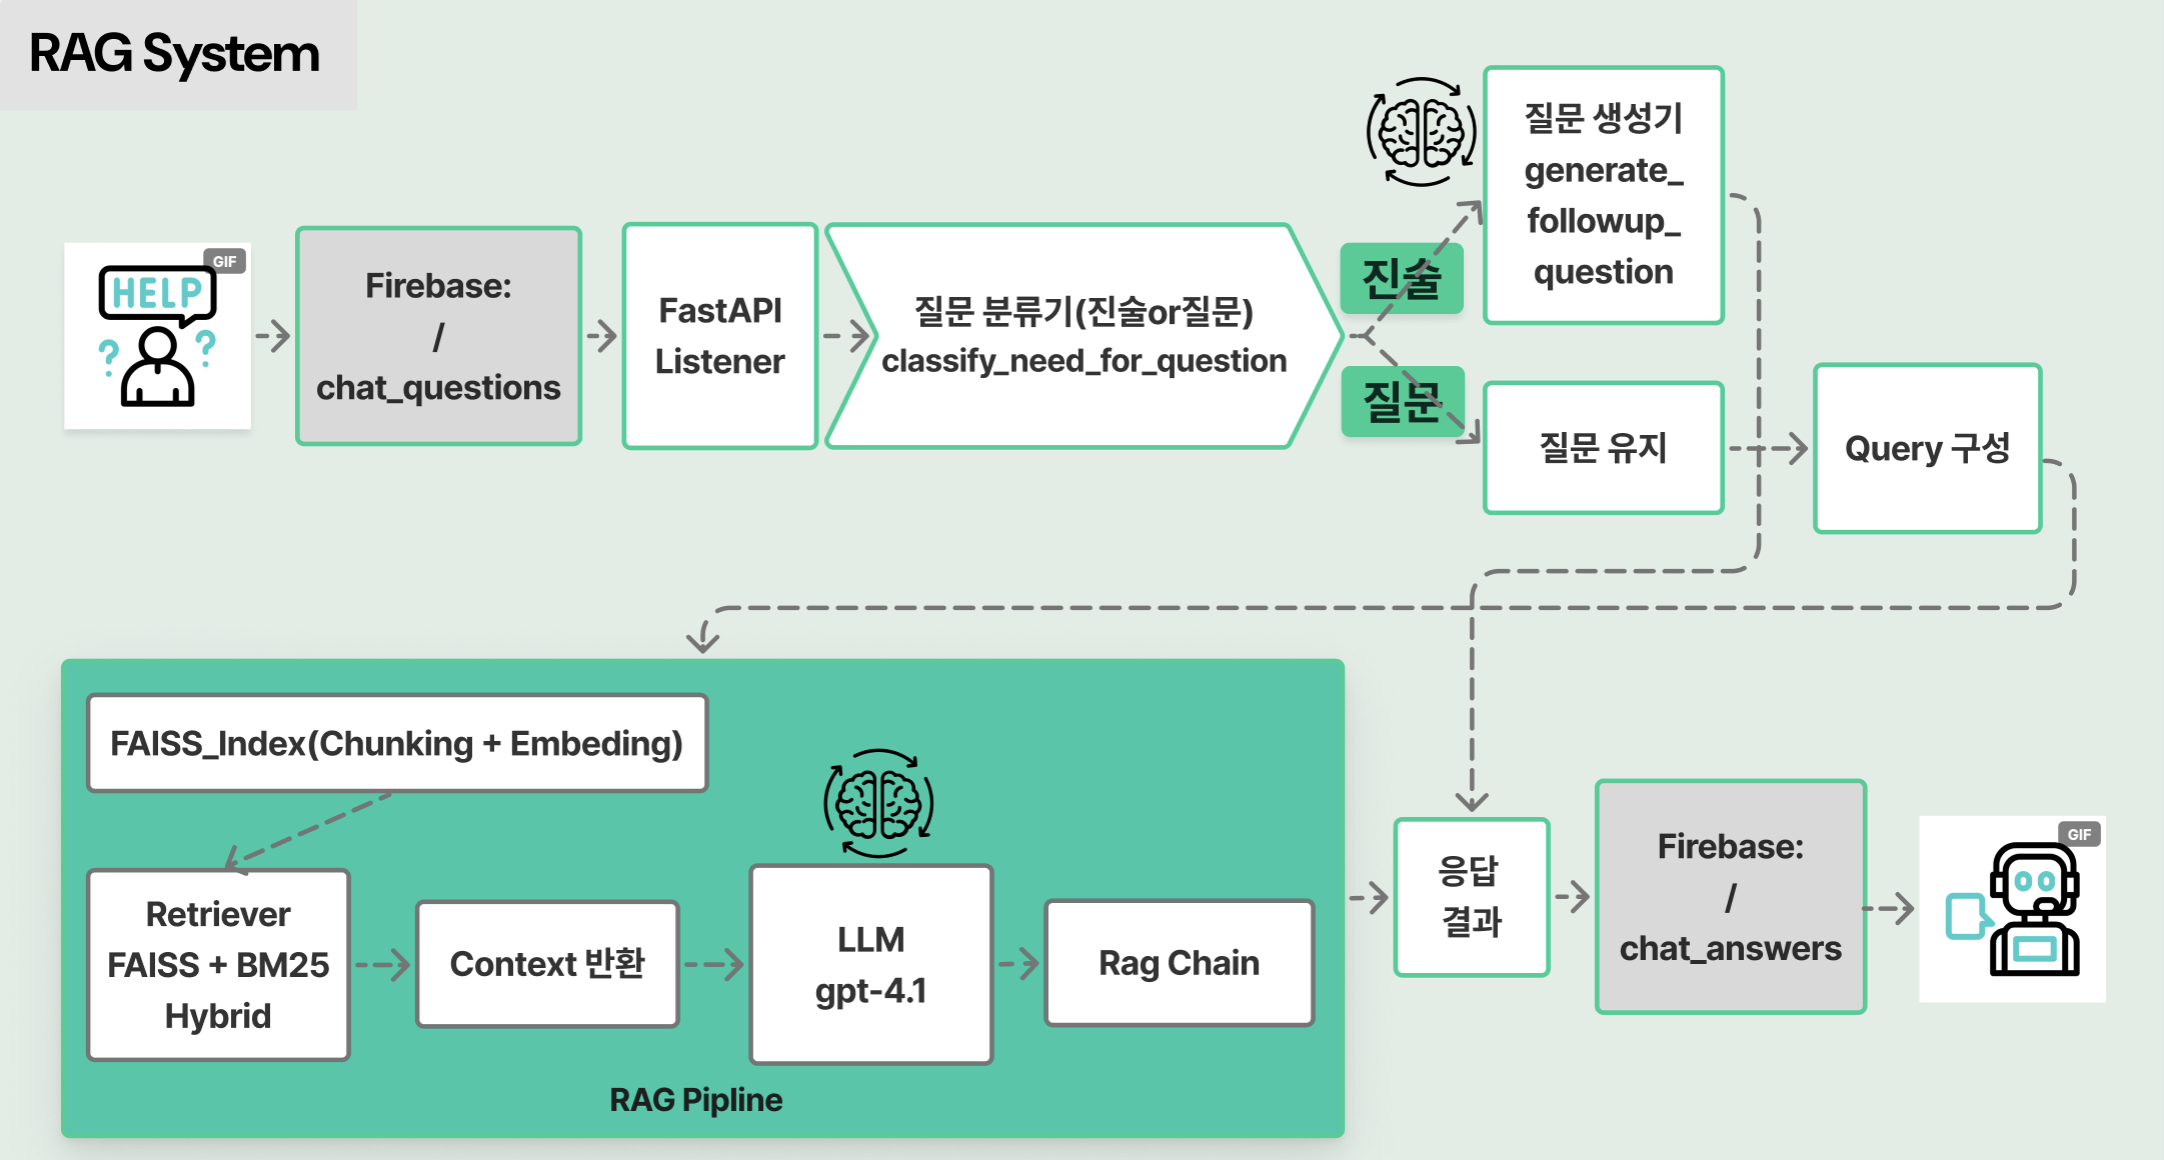


✅실제 구현 순서

1. 사용자가 질문을 입력하면, FastAPI가 Firebase에서 이를 감지해 처리합니다.
2. 입력된 내용이 질문인지 단순 진술인지 분류합니다.
3. 진술일 경우, 의미를 명확히 하기 위해 후속 질문을 생성합니다.
4. 질문일 경우, 쿼리를 구성합니다.
5. FAISS와 BM25를 결합한 하이브리드 리트리버가 관련 문서를 검색합니다.
6. 검색된 문서를 바탕으로 LLM이 자연어 답변을 생성합니다.
7. 최종 답변과 후속 질문은 Firebase에 저장합니다.

    base_folder_path = "/content/drive/MyDrive/nomu_dataset3" # <<< 원본 데이터 폴더 경로 확인!
    result_dir = "/content/drive/MyDrive/nomu_rag_result"    # <<< 결과 저장 폴더 경로 확인!

# 0: 필요한 라이브러리 설치 (OpenAI 추가)

In [ ]:
# === 단계 0: 필요한 라이브러리 설치 (의존성 충돌 해결 버전 + OpenAI 추가) ===
print("--- 단계 0: 라이브러리 설치 시작 (OpenAI 추가) ---")
!pip install -qU \
    langchain langchain-core langchain-community langchain-openai openai \
    pypdf openpyxl xlrd unstructured faiss-cpu sentence-transformers \
    pdf2image pillow pdfminer.six rank_bm25 pillow-heif jq \
    google-api-python-client google-auth-httplib2 google-auth-oauthlib gspread \
    ragas datasets \
    pandas==2.2.2 \
    PyPDF2 \
    fsspec==2025.3.2 # <<< fsspec 버전은 환경에 따라 조정 필요, 원래 버전 사용

# google-ai-generativelanguage는 OpenAI 사용 시 필수는 아님 (필요시 유지)
# !pip install -qU google-ai-generativelanguage==0.6.15

print("\n[알림] 라이브러리 설치/업데이트 완료. langchain-openai, openai 추가됨.")

--- 단계 0: 라이브러리 설치 시작 (OpenAI 추가) ---
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 15.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 437.9/437.9 kB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 27.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.9/62.9 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 683.3/683.3 kB 31.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 303.4/303.4 kB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 48.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 40.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 55.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 60.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 746.6/746.6 kB 37.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.0/60

# 1: 기본 및 필요 라이브러리 임포트 (OpenAI LLM 임포트 추가)

In [ ]:
# === 단계 1: 기본 및 필요 라이브러리 임포트 ===

import os
import glob
import subprocess
import sys
import warnings
import time
import pandas as pd
from google.colab import drive, auth, userdata
import PyPDF2 # 명시적 임포트
import json
import pickle
import torch
import numpy as np
from tqdm.notebook import tqdm
import gspread
from google.auth import default as google_auth_default
from datasets import Dataset
import re
import traceback # 오류 상세 출력을 위해 추가

# LangChain 관련 임포트
from langchain_core.documents import Document
from langchain_community.document_loaders import (
    PyPDFLoader, UnstructuredExcelLoader, CSVLoader,
    UnstructuredFileLoader, DirectoryLoader, GoogleDriveLoader
)
from langchain.text_splitter import RecursiveCharacterTextSplitter
# from langchain_google_genai import GoogleGenerativeAIEmbeddings # Google 임베딩 (필요 시 유지)
from langchain_community.embeddings import HuggingFaceEmbeddings # HuggingFace 임베딩 (유지)
from langchain_community.vectorstores import FAISS
from langchain_community.retrievers import BM25Retriever
from langchain.retrievers import EnsembleRetriever
# === LLM 임포트 변경 ===
# from langchain_google_genai import ChatGoogleGenerativeAI # <<< 삭제 또는 주석 처리
from langchain_openai import ChatOpenAI # <<< OpenAI LLM 클래스 임포트
# =======================
from langchain.chains import RetrievalQA
from langchain.prompts import PromptTemplate

# RAGAS 관련 임포트 (기존 유지)
try:
    from ragas import evaluate
    from ragas.metrics import context_precision, context_recall, faithfulness, answer_relevancy
    from ragas.llms import LangchainLLMWrapper
    from ragas.embeddings import LangchainEmbeddingsWrapper
except ImportError:
    print("!! Ragas 관련 라이브러리가 설치되지 않았습니다. 평가 단계 전에 설치가 필요합니다.")
    LangchainLLMWrapper = None; LangchainEmbeddingsWrapper = None; context_precision = None; context_recall = None; faithfulness = None; answer_relevancy = None

# 기타 평가 관련 임포트 (기존 유지)
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
# import google.generativeai as genai # OpenAI 사용 시 필수는 아님

warnings.filterwarnings("ignore") # 경고 메시지 숨기기

print("--- 단계 1: 라이브러리 임포트 완료 (ChatOpenAI 임포트됨) ---")

--- 단계 1: 라이브러리 임포트 완료 (ChatOpenAI 임포트됨) ---


In [ ]:
import ragas
print(ragas.__version__)


0.2.15


# 2: 환경 설정 (OpenAI API 키 추가)

    base_folder_path = "/content/drive/MyDrive/nomu_dataset3" # <<< 원본 데이터 폴더 경로 확인!
    result_dir = "/content/drive/MyDrive/nomu_rag_result"    # <<< 결과 저장 폴더 경로 확인!
    # <<< nomu_dataset3 폴더의 실제 ID로 변경하거나 확인! >>>
예)
    https://drive.google.com/drive/u/0/folders/1FIA_HGeYbRVaH_USuxUdjhFAoReUTo9U

target_folder_id = "1FIA_HGeYbRVaH_USuxUdjhFAoReUTo9U"

In [ ]:
# === 단계 2: 환경 설정 (Drive 마운트, API 키, 경로) ===
print("\n--- 단계 2: 환경 설정 시작 ---")

# --- Google Drive 마운트 (기존 유지) ---
DRIVE_MOUNTED = False
try:
    drive.mount('/content/drive', force_remount=False)
    DRIVE_MOUNTED = True
    print("[성공] Google Drive 마운트 완료.")
except Exception as e:
    print(f"[실패] Google Drive 마운트 오류: {e}")

# --- Google 인증 (Colab 사용자 인증 - 필요시 유지) ---
# Google Drive Loader 등을 사용한다면 인증 유지 필요
try:
    auth.authenticate_user()
    print("[성공] Google Colab 사용자 인증 완료.")
except Exception as e:
    print(f"[실패] Google Colab 인증 오류: {e}")

# === API 키 설정 변경 ===
# --- OpenAI API 키 설정 ---
OPENAI_API_KEY = None
try:
    OPENAI_API_KEY = userdata.get('OPENAI_API_KEY') # Colab Secrets 우선 확인
    if not OPENAI_API_KEY: OPENAI_API_KEY = os.environ.get('OPENAI_API_KEY') # 환경 변수 확인
    if not OPENAI_API_KEY: raise ValueError("OpenAI API 키를 Colab Secrets 또는 환경 변수에서 찾을 수 없습니다.")
    os.environ["OPENAI_API_KEY"] = OPENAI_API_KEY
    print("[성공] OpenAI API 키 로드 및 설정 완료.")
except Exception as e:
    print(f"[실패] OpenAI API 키 로드/설정 오류: {e}")
    print("   !! OpenAI API 키 없이는 이후 LLM, RAGAS 평가 등 사용 불가 !!")

# --- Google AI API 키 설정 (선택 사항) ---
# 만약 Google Embedding 등을 계속 사용한다면 유지, 아니면 제거 가능
# GOOGLE_API_KEY = None
# try:
#     GOOGLE_API_KEY = userdata.get('GOOGLE_API_KEY')
#     if not GOOGLE_API_KEY: GOOGLE_API_KEY = os.environ.get('GOOGLE_API_KEY')
#     if GOOGLE_API_KEY:
#         os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY
#         import google.generativeai as genai
#         genai.configure(api_key=GOOGLE_API_KEY)
#         print("[정보] Google API 키 로드 및 설정 완료 (선택 사항).")
#     # else: print("[정보] Google API 키 로드 안 됨 (선택 사항).") # 키 없어도 오류 아님
# except Exception as e: print(f"[경고] Google API 키 설정 중 오류 발생 (선택 사항): {e}")
# =========================

# --- 경로 설정 (기존 유지) ---
if DRIVE_MOUNTED:
    base_folder_path = "/content/drive/MyDrive/nomu_dataset3"
    result_dir = "/content/drive/MyDrive/nomu_rag_result"
else:
    base_folder_path = "./nomu_data_local"
    result_dir = "./nomu_rag_result_local"

print(f"데이터 소스 검색 경로: {base_folder_path}")
print(f"결과 저장 경로: {result_dir}")
os.makedirs(base_folder_path, exist_ok=True)
os.makedirs(result_dir, exist_ok=True)

# Google Sheets 폴더 ID (필요시 유지)
target_folder_id = "1FIA_HGeYbRVaH_USuxUdjhFAoReUTo9U"
print(f"Google Sheets 검색 대상 폴더 ID: {target_folder_id}")

# --- 결과 파일 경로 (기존 유지) ---
vs_status_file = os.path.join(result_dir, "vectorstore_build_status.json")
vs_checkpoint_path = os.path.join(result_dir, "faiss_index_nomu_checkpoint")
vs_final_save_path = os.path.join(result_dir, "faiss_index_nomu_final")
bm25_data_save_path = os.path.join(result_dir, "split_texts_for_bm25.pkl")

print("--- 단계 2: 환경 설정 완료 (OpenAI API 키 설정됨) ---")


--- 단계 2: 환경 설정 시작 ---
Mounted at /content/drive
[성공] Google Drive 마운트 완료.
[성공] Google Colab 사용자 인증 완료.
[성공] OpenAI API 키 로드 및 설정 완료.
데이터 소스 검색 경로: /content/drive/MyDrive/nomu_dataset3
결과 저장 경로: /content/drive/MyDrive/nomu_rag_result
Google Sheets 검색 대상 폴더 ID: 1FIA_HGeYbRVaH_USuxUdjhFAoReUTo9U
--- 단계 2: 환경 설정 완료 (OpenAI API 키 설정됨) ---


# 3: LLM 두 개 선언

qa_llm → RetrievalQA 체인의 LLM으로 사용

eval_llm → LangchainLLM(llm=eval_llm) 로 RAGAS evaluate() 함수에 들어감

평가 모델(eval_llm)은 고정해두는 게 비교 분석할 때 더 일관성 있어요

응답 생성용(qa_llm)은 실험적으로 변경해가며 비교하면 좋아요

리트리버 결과(source documents) 평가할 때도 eval_llm을 사용합니다.

생성된 답변(result) 평가할 때도 eval_llm을 사용합니다.

In [ ]:
from langchain_openai import ChatOpenAI

# 응답 생성용 LLM
qa_llm = ChatOpenAI(
    model_name="gpt-4.1",
    temperature=0,
    openai_api_key=os.getenv("OPENAI_API_KEY")
)

# 평가용 LLM (RAGAS용)
eval_llm = ChatOpenAI(
    model_name="gpt-4.1-nano",
    temperature=0,
    openai_api_key=os.getenv("OPENAI_API_KEY")
)


# 4: 데이터 로딩

In [ ]:
# === 단계 4: 데이터 로딩  ===

print("\n--- 단계 4: 데이터 로딩 시작 ---")

loaded_documents = []
loading_errors = {}

# --- 4.1. Google Sheets 로딩 ---
print("\n--- 3.1 Google Sheets 파일 로딩 ---")
if not target_folder_id or "YOUR_" in target_folder_id:
    print("  ⚠️ 경고: Google Drive 폴더 ID가 유효하지 않아 Google Sheet 로딩 건너<0xEB><0x9A><A9>니다.")
elif not DRIVE_MOUNTED:
     print("  ⚠️ 경고: Google Drive가 마운트되지 않아 Google Sheet 로딩 건너<0xEB><0x9A><A9>니다.")
else:
    try:
        gsheet_loader = GoogleDriveLoader(folder_id=target_folder_id, file_types=["sheet"], recursive=True)
        print(f"  GoogleDriveLoader로 폴더 '{target_folder_id}' 로딩 중...")
        gsheet_docs = gsheet_loader.load()
        if gsheet_docs:
            print(f"  [성공] Google Sheets 로딩 ({len(gsheet_docs)}개 조각).")
            for doc in gsheet_docs:
                doc.metadata['file_type'] = 'google_sheet'
                if 'source' not in doc.metadata and 'id' in doc.metadata:
                    doc.metadata['source'] = f"https://docs.google.com/spreadsheets/d/{doc.metadata['id']}"
            loaded_documents.extend(gsheet_docs)
        else: print("  [정보] 해당 폴더에 Google Sheets 파일 없음.")
    except ImportError as ie: print(f"  ❌ 임포트 오류: {ie}. 관련 라이브러리 설치 필요."); loading_errors['google_sheets'] = str(ie)
    except Exception as e: error_msg = f"{type(e).__name__}: {e}"; print(f"  ❌ 로딩 오류: {error_msg}"); loading_errors['google_sheets'] = error_msg

# --- 4.2. 다른 파일 형식 로딩 (PDF, Excel, CSV, TXT 등) ---
print("\n--- 3.2 다른 파일 형식 로딩 (DirectoryLoader) ---")
if not DRIVE_MOUNTED and not os.path.exists(base_folder_path):
    print(f"  ⚠️ 경고: Drive 미마운트 및 로컬 경로({base_folder_path}) 없음. 파일 로딩 건너<0xEB><0x9A><A9>니다.")
else:
    LOADER_MAPPING = { ".pdf": (PyPDFLoader, {}), ".xlsx": (UnstructuredExcelLoader, {"mode": "single"}), ".xls": (UnstructuredExcelLoader, {"mode": "single"}), ".csv": (CSVLoader, {"encoding": "utf-8"}), ".txt": (UnstructuredFileLoader, {}) }
    supported_extensions = list(LOADER_MAPPING.keys())
    for ext in supported_extensions:
        print(f"\n  '{ext}' 확장자 로딩 ({base_folder_path})...")
        loader_cls, loader_args = LOADER_MAPPING[ext]
        try:
            loader = DirectoryLoader( base_folder_path, glob=f"**/*{ext}", loader_cls=loader_cls, loader_kwargs=loader_args, recursive=True, show_progress=True, use_multithreading=True, silent_errors=False )
            docs = loader.load()
            if docs:
                print(f"    [성공] '{ext}' 로딩 ({len(docs)}개 조각).")
                for doc in docs: doc.metadata['file_type'] = ext.lstrip('.')
                loaded_documents.extend(docs)
            else: print(f"    [정보] '{ext}' 파일 없음.")
        except ImportError as ie: error_msg = f"{ie}"; print(f"    ❌ 임포트 오류: {error_msg}"); loading_errors[f'loader_{ext}'] = f"ImportError: {error_msg}"
        except Exception as e: error_msg = f"{type(e).__name__}: {e}"; print(f"    ❌ 로딩 오류: {error_msg}"); loading_errors[f'loader_{ext}'] = error_msg

# --- 4.3. 로딩 결과 요약 ---
print(f"\n--- 최종 로드된 문서 조각 수: {len(loaded_documents)} ---")
doc_type_counts = {}
for doc in loaded_documents: file_type = doc.metadata.get('file_type', 'unknown'); doc_type_counts[file_type] = doc_type_counts.get(file_type, 0) + 1
print("\n--- 로드된 문서 타입별 개수 ---");
if doc_type_counts: [print(f"  - {f_type}: {count}개 조각") for f_type, count in sorted(doc_type_counts.items())]
else: print("  로드된 문서 없음.")
if loading_errors: print("\n--- 로딩 오류 요약 ---"); [print(f"  - {src}: {err}") for src, err in loading_errors.items()]
if loaded_documents:
    print("\n--- 첫 로드 문서 샘플 ---")
    try: first_doc = loaded_documents[0]; print(f"  타입: {first_doc.metadata.get('file_type')}\n  메타데이터: {first_doc.metadata}\n  내용(200자): {first_doc.page_content[:200]}...")
    except Exception as e: print(f"  !! 샘플 출력 오류: {e}")
else: print("\n로드된 문서 없음. 경로, 파일 형식, 권한 확인 필요.")
print("\n--- 단계 4: 데이터 로딩 완료 ---")



--- 단계 4: 데이터 로딩 시작 ---

--- 3.1 Google Sheets 파일 로딩 ---
  GoogleDriveLoader로 폴더 '1FIA_HGeYbRVaH_USuxUdjhFAoReUTo9U' 로딩 중...
  [성공] Google Sheets 로딩 (89개 조각).

--- 3.2 다른 파일 형식 로딩 (DirectoryLoader) ---

  '.pdf' 확장자 로딩 (/content/drive/MyDrive/nomu_dataset3)...


100%|██████████| 125/125 [00:31<00:00,  3.97it/s]


    [성공] '.pdf' 로딩 (1748개 조각).

  '.xlsx' 확장자 로딩 (/content/drive/MyDrive/nomu_dataset3)...


0it [00:00, ?it/s]


    [정보] '.xlsx' 파일 없음.

  '.xls' 확장자 로딩 (/content/drive/MyDrive/nomu_dataset3)...


0it [00:00, ?it/s]


    [정보] '.xls' 파일 없음.

  '.csv' 확장자 로딩 (/content/drive/MyDrive/nomu_dataset3)...


0it [00:00, ?it/s]


    [정보] '.csv' 파일 없음.

  '.txt' 확장자 로딩 (/content/drive/MyDrive/nomu_dataset3)...


0it [00:00, ?it/s]

    [정보] '.txt' 파일 없음.

--- 최종 로드된 문서 조각 수: 1837 ---

--- 로드된 문서 타입별 개수 ---
  - google_sheet: 89개 조각
  - pdf: 1748개 조각

--- 첫 로드 문서 샘플 ---
  타입: google_sheet
  메타데이터: {'source': 'https://docs.google.com/spreadsheets/d/1QeMvmrcYe6QQ8L1n6o1NQ7ASTPafmzdbuDAAKXFCu3k/edit?gid=0', 'title': 'filtered_qa_dataset - Sheet1', 'row': 1, 'file_type': 'google_sheet'}
  내용(200자): No.: 0
question: 근로계약이 미성년자에게 불리하다고 인정되는 경우 미성년후견인은 그 계약을 해지할 수 있나요?
answer: 네. 근로계약을 해지할 수 있습니다.
ground_truths: ["「근로기준법」 제67조 제2항은 친권자,후견인 또는 고용노동부장관은 근로계약이 미성년자에게 불리하다고 인정하는 경우에는 이를 해지할 수 있다."라고 규정...

--- 단계 4: 데이터 로딩 완료 ---


# 5: 텍스트 분할 (Chunking, 패턴 기반 + 길이 제한)

형사처벌/벌금/과태료 등 중요한 조항을 청크로 정확히 보존하고, fallback 분할도 완화하며, 검증용 로그도 포함한 전체 청킹 코드

형사처벌 조항 regex 선별 추가 포함

✅ 형사처벌 관련 조항을 우선적으로 정규식 기반으로 추출하여 단독 청크로 분리했습니다.

✅ 중복 삽입 방지를 위해 already_added_chunks 집합을 사용했습니다.

✅ 기존 "제X조" 기반 청킹에서 중복 조항 추가를 방지하도록 조건 추가했습니다.

In [ ]:
import re
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_core.documents import Document
from tqdm import tqdm

print("\n--- 단계 5: 텍스트 분할 시작 (형사처벌 조항 우선 보존 + 중복 방지 적용) ---")

# 설정값
chunk_size_setting = 500
chunk_overlap_setting = 100

# 제재 관련 중요 키워드
important_keywords = ["형사", "벌금", "과태료", "처벌"]

# fallback용 스플리터
fallback_splitter = RecursiveCharacterTextSplitter(
    chunk_size=800,
    chunk_overlap=200
)

split_texts = []
already_added_chunks = set()  # ✅ 중복 방지용 집합

if 'loaded_documents' in locals() and loaded_documents:
    print(f"[정보] 패턴 기반 청킹 시도 (법령 PDF 대상). 기준 크기={chunk_size_setting}, 중첩={chunk_overlap_setting}")
    processed_docs_count = 0
    skipped_docs_count = 0

    for doc in tqdm(loaded_documents, desc="문서 청킹 중"):
        doc_content = doc.page_content
        doc_metadata = doc.metadata
        file_type = doc_metadata.get('file_type', 'unknown')

        if file_type != 'pdf' or not doc_content.strip():
            if doc_content.strip():
                try:
                    sub_chunks = fallback_splitter.split_text(doc_content)
                    for chunk_text in sub_chunks:
                        split_texts.append(Document(page_content=chunk_text, metadata=doc_metadata.copy()))
                    processed_docs_count += 1
                except Exception as e:
                    print(f"\n!! 기본 분할 오류 (타입: {file_type}, 소스: {doc_metadata.get('source', 'N/A')}): {e}")
                    skipped_docs_count += 1
            else:
                skipped_docs_count += 1
            continue

        try:
            # ✅ Step 1: 형사처벌 조항을 정규식으로 찾아 단독 청크로 우선 보존
            penalty_matches = re.findall(r'(제\s?\d+\s?조.*?(형사|벌금|과태료|처벌)[^제]{0,500})', doc_content)
            for match in penalty_matches:
                matched_text = match[0].strip()
                if matched_text not in already_added_chunks:
                    split_texts.append(Document(page_content=matched_text, metadata=doc_metadata.copy()))
                    already_added_chunks.add(matched_text)

            # Step 2: "제X조" 단위로 분할하여 일반 조항 처리
            preliminary_chunks_with_title = re.split(r'(제\s?\d+\s?조)', doc_content)
            current_chunk_content = ""
            if preliminary_chunks_with_title[0].strip():
                current_chunk_content = preliminary_chunks_with_title[0].strip()

            for i in range(1, len(preliminary_chunks_with_title), 2):
                title = preliminary_chunks_with_title[i]
                content = preliminary_chunks_with_title[i+1] if (i+1) < len(preliminary_chunks_with_title) else ""
                article_block = title + content

                # ✅ 형사/과태료/벌금 포함된 조항은 이미 추가된 경우 제외
                if any(kw in article_block for kw in important_keywords):
                    if article_block.strip() not in already_added_chunks:
                        split_texts.append(Document(page_content=article_block.strip(), metadata=doc_metadata.copy()))
                        already_added_chunks.add(article_block.strip())
                    current_chunk_content = ""
                    continue

                if current_chunk_content and (len(current_chunk_content) + len(article_block) <= chunk_size_setting):
                    current_chunk_content += "\n\n" + article_block
                else:
                    if current_chunk_content:
                        if len(current_chunk_content) > chunk_size_setting:
                            sub_chunks = fallback_splitter.split_text(current_chunk_content)
                            for chunk_text in sub_chunks:
                                split_texts.append(Document(page_content=chunk_text, metadata=doc_metadata.copy()))
                        else:
                            split_texts.append(Document(page_content=current_chunk_content, metadata=doc_metadata.copy()))
                    current_chunk_content = article_block.strip()

            if current_chunk_content:
                if len(current_chunk_content) > chunk_size_setting:
                    sub_chunks = fallback_splitter.split_text(current_chunk_content)
                    for chunk_text in sub_chunks:
                        split_texts.append(Document(page_content=chunk_text, metadata=doc_metadata.copy()))
                else:
                    split_texts.append(Document(page_content=current_chunk_content, metadata=doc_metadata.copy()))

            processed_docs_count += 1

        except Exception as e:
            print(f"\n!! 패턴 기반 분할 오류 (소스: {doc_metadata.get('source', 'N/A')}): {e}")
            try:
                sub_chunks = fallback_splitter.split_text(doc_content)
                for chunk_text in sub_chunks:
                    split_texts.append(Document(page_content=chunk_text, metadata=doc_metadata.copy()))
                print("  -> 오류 발생하여 fallback 방식으로 처리함.")
                processed_docs_count += 1
            except Exception as fallback_e:
                print(f"  -> fallback 방식도 실패: {fallback_e}")
                skipped_docs_count += 1

    print(f"\n[성공] 총 {processed_docs_count}개 문서 → {len(split_texts)}개 청크 분할 완료.")
    if skipped_docs_count > 0:
        print(f"[경고] {skipped_docs_count}개 문서 처리 실패.")

    penalty_chunks = [c for c in split_texts if any(kw in c.page_content for kw in important_keywords)]
    print(f"\n[검증] '형사/과태료/벌금' 포함 청크 수: {len(penalty_chunks)}")

    if split_texts:
        print(f"\n샘플 청크:\n{split_texts[0].page_content[:200]}...")
        print(f"메타데이터: {split_texts[0].metadata}")
else:
    print("!! 분할할 문서가 없습니다.")

print("--- 단계 5: 텍스트 분할 완료 ---")



--- 단계 5: 텍스트 분할 시작 (형사처벌 조항 우선 보존 + 중복 방지 적용) ---
[정보] 패턴 기반 청킹 시도 (법령 PDF 대상). 기준 크기=500, 중첩=100


문서 청킹 중: 100%|██████████| 1837/1837 [00:00<00:00, 8147.41it/s]


[성공] 총 1837개 문서 → 8854개 청크 분할 완료.

[검증] '형사/과태료/벌금' 포함 청크 수: 498

샘플 청크:
No.: 0
question: 근로계약이 미성년자에게 불리하다고 인정되는 경우 미성년후견인은 그 계약을 해지할 수 있나요?
answer: 네. 근로계약을 해지할 수 있습니다.
ground_truths: ["「근로기준법」 제67조 제2항은 친권자,후견인 또는 고용노동부장관은 근로계약이 미성년자에게 불리하다고 인정하는 경우에는 이를 해지할 수 있다."라고 규정...
메타데이터: {'source': 'https://docs.google.com/spreadsheets/d/1QeMvmrcYe6QQ8L1n6o1NQ7ASTPafmzdbuDAAKXFCu3k/edit?gid=0', 'title': 'filtered_qa_dataset - Sheet1', 'row': 1, 'file_type': 'google_sheet'}
--- 단계 5: 텍스트 분할 완료 ---


# 수집된 '형사처벌/과태료/벌금' 포함 청크 확인 코드

In [ ]:
penalty_chunks = [c for c in split_texts if "제37조" in c.page_content or "300만 원" in c.page_content]
for i, c in enumerate(penalty_chunks):
    print(f"\n[형사처벌 청크 {i+1}]:\n{c.page_content[:500]}")

# 6: 임베딩 모델 설정 (OpenAI: text-embedding-3-large)

In [ ]:
# === 단계 6: 임베딩 모델 설정 (OpenAI: text-embedding-3-large) ===
print("\n--- 단계 6: 임베딩 모델 설정 시작 (OpenAI: text-embedding-3-large) ---") # <<< 모델 이름 변경

# 필요한 라이브러리 임포트
try:
    # OpenAI 임베딩을 위한 클래스 임포트
    # pip install -U langchain-openai  <-- 먼저 이 패키지를 설치해야 합니다.
    from langchain_openai import OpenAIEmbeddings
    print("[정보] langchain_openai.OpenAIEmbeddings 임포트 확인.")
except ImportError as e:
    print(f"!! [오류] 필요한 라이브러리 임포트 실패: {e}")
    print("   langchain-openai, openai 패키지가 설치되었는지 확인하세요.")
    # 필요한 클래스가 없으면 이후 진행 불가
    OpenAIEmbeddings = None

embeddings = None # 최종 임베딩 객체 변수 초기화

if OpenAIEmbeddings: # 라이브러리 임포트 성공 시 진행
    try:
        # 사용할 OpenAI 모델 지정 (text-embedding-3-large로 변경)
        openai_model_name = "text-embedding-3-large" # <<< 모델 이름 변경 (여기를 수정했습니다)
        print(f"[정보] OpenAI 임베딩 모델 ({openai_model_name}) 설정 시도...")
        print("[정보] 단계 2에서 설정된 OPENAI_API_KEY 환경 변수를 사용합니다.")

        # <<< OpenAIEmbeddings 클래스 사용 (API 키 자동 감지) >>>
        # 단계 2에서 os.environ["OPENAI_API_KEY"] 가 설정되었으므로,
        # API 키를 명시적으로 전달할 필요 없이 자동으로 사용됩니다.
        embeddings = OpenAIEmbeddings(
            model=openai_model_name # 수정된 모델 이름 사용
            # openai_api_key 파라미터 생략
            # text-embedding-3-large는 기본 차원(3072) 외에
            # 다른 차원(e.g., 1536, 512)을 지정할 수 있습니다. 필요시 dimensions 파라미터 추가.
            # 예: dimensions=1536
        )
        # ------------------------------------------------------

        # 간단한 테스트 (API 키 유효성 및 통신 확인)
        print("[정보] 임베딩 모델 테스트 중 (OpenAI API 호출)...")
        _ = embeddings.embed_query("테스트 문장입니다.")
        print(f"[성공] OpenAI 임베딩 모델 ({openai_model_name}) 설정 및 테스트 완료.") # <<< 출력 메시지 변경 (변수 사용으로 자동 반영)

    except Exception as e:
        print(f"!! [오류] OpenAI 임베딩 모델 ({openai_model_name}) 설정 실패: {e}") # <<< 출력 메시지 변경 (변수 사용으로 자동 반영)
        print("   - 단계 2에서 OpenAI API 키가 올바르게 설정되었는지 확인하세요.")
        print("   - OpenAI API 키 자체의 유효성 및 할당량(quota)을 확인하세요.")
        print("   - 인터넷 연결 상태 및 OpenAI 서비스 상태를 확인하세요.")
        print("   - 관련 라이브러리(langchain-openai, openai) 설치 및 호환성을 확인하세요.")
        # text-embedding-3-large 모델 접근 권한이 계정에 있는지 확인 필요할 수 있음
        embeddings = None # 실패 시 None으로 설정
else:
    print("!! 필요한 라이브러리(OpenAIEmbeddings) 임포트 실패. 임베딩 모델 설정 불가.")

print("--- 단계 6: 임베딩 모델 설정 완료 ---")

# OpenAI 모델은 외부 API를 사용하므로 로컬 GPU/CPU 확인은 불필요합니다.


--- 단계 6: 임베딩 모델 설정 시작 (OpenAI: text-embedding-3-large) ---
[정보] langchain_openai.OpenAIEmbeddings 임포트 확인.
[정보] OpenAI 임베딩 모델 (text-embedding-3-large) 설정 시도...
[정보] 단계 2에서 설정된 OPENAI_API_KEY 환경 변수를 사용합니다.
[정보] 임베딩 모델 테스트 중 (OpenAI API 호출)...
[성공] OpenAI 임베딩 모델 (text-embedding-3-large) 설정 및 테스트 완료.
--- 단계 6: 임베딩 모델 설정 완료 ---


# 7: Vector Store 구축 (FAISS)

--- 7: 경로 설정 ---
📂 결과 저장 경로: /content/drive/MyDrive/nomu_rag_result
  - 상태 파일: /content/drive/MyDrive/nomu_rag_result/vectorstore_build_status.json
  - 체크포인트 폴더 (FAISS): /content/drive/MyDrive/nomu_rag_result/faiss_index_nomu_checkpoint
  - 최종 인덱스 폴더 (FAISS): /content/drive/MyDrive/nomu_rag_result/faiss_index_nomu_final
  - BM25용 데이터 파일: /content/drive/MyDrive/nomu_rag_result/split_texts_for_bm25.pkl

In [ ]:
# -*- coding: utf-8 -*-
# === 단계 7: Vector Store 구축 (FAISS) 및 BM25용 데이터 저장 ===
# 체크포인팅 방식을 save_local로 변경

import time
import os
import json
# import pickle # pickle은 BM25 데이터 저장에만 사용
import torch
import traceback
from tqdm.auto import tqdm
# LangChain 관련 임포트 확인
if 'FAISS' not in locals() or 'Document' not in locals():
    from langchain_community.vectorstores import FAISS
    from langchain_core.documents import Document
    print("⚠️ FAISS 또는 Document 클래스 재임포트됨.")
if 'HuggingFaceEmbeddings' not in locals() and 'GoogleGenerativeAIEmbeddings' not in locals():
    # 사용 중인 임베딩 클래스를 임포트해야 합니다.
    from langchain_community.embeddings import HuggingFaceEmbeddings # 예시
    # from langchain_google_genai import GoogleGenerativeAIEmbeddings # 예시
    print("⚠️ 임베딩 클래스 재임포트됨.")


print("\n--- 단계 6: Vector Store 구축 및 BM25 데이터 저장 시작 ---")

# --- 7.1: 설정 및 입력 변수 확인 ---
print("\n--- 7.1: 설정 및 입력 변수 확인 ---")
vectorstore = None
batch_size = 500 # 배치 크기 확인
sleep_time = 5
max_retries = 3
total_chunks = 0
start_index = 0
loaded_from_checkpoint = False

if 'split_texts' not in locals() or not isinstance(split_texts, list) or not split_texts: print("!! 오류: 'split_texts' 없음. 중단."); exit()
elif 'embeddings' not in locals() or embeddings is None: print("!! 오류: 'embeddings' 없음. 중단."); exit()
else: total_chunks = len(split_texts); print(f"✅ 입력 확인: 총 {total_chunks}개 청크 및 임베딩 모델 확인됨.")

# --- 7.2: 경로 설정 및 디렉토리 생성 ---
print("\n--- 7.2: 경로 설정 ---")
if 'result_dir' not in locals() or not result_dir: result_dir = "/content/drive/MyDrive/nomu_rag_result"; print(f"⚠️ result_dir 변수 없어 기본 경로 설정: {result_dir}"); os.makedirs(result_dir, exist_ok=True)
else: print(f"📂 결과 저장 경로: {result_dir}"); os.makedirs(result_dir, exist_ok=True)

vs_status_file = os.path.join(result_dir, "vectorstore_build_status.json")
# <<< 체크포인트 경로를 폴더로 변경 (save_local 사용) >>>
vs_checkpoint_path = os.path.join(result_dir, "faiss_index_nomu_checkpoint") # .pkl 대신 폴더명
vs_final_save_path = os.path.join(result_dir, "faiss_index_nomu_final")
bm25_data_save_path = os.path.join(result_dir, "split_texts_for_bm25.pkl")

print(f"  - 상태 파일: {vs_status_file}")
print(f"  - 체크포인트 폴더 (FAISS): {vs_checkpoint_path}") # <<< 이름 변경
print(f"  - 최종 인덱스 폴더 (FAISS): {vs_final_save_path}")
print(f"  - BM25용 데이터 파일: {bm25_data_save_path}")

# --- 7.3: GPU 확인 --- (이전과 동일)
print("\n--- 7.3: 장치 확인 ---")
device = 'cuda' if torch.cuda.is_available() else 'cpu'; print(f"ℹ️ 사용할 장치: {device}");
if device == 'cpu': print("⚠️ 경고: GPU 사용 불가. 시간 소요 예상.")

# --- 7.4: 이전 작업 상태 및 체크포인트 로드 ---
if total_chunks > 0:
    print("\n--- 7.4: 이전 작업 상태 및 체크포인트 로드 ---")
    try:
        # <<< 체크포인트 파일 대신 폴더 존재 여부 확인 >>>
        if os.path.exists(vs_status_file) and os.path.isdir(vs_checkpoint_path):
            with open(vs_status_file, 'r') as f_status: status_data = json.load(f_status); last_processed_index = status_data.get('last_processed_index', -1); start_index = last_processed_index + 1; print(f"  - 상태 로드 완료. 마지막 인덱스: {last_processed_index}")

            # <<< pickle.load 대신 FAISS.load_local 사용 >>>
            print(f"  - 체크포인트 인덱스 로딩: {vs_checkpoint_path}")
            if 'embeddings' in locals() and embeddings:
                vectorstore = FAISS.load_local(
                    folder_path=vs_checkpoint_path,
                    embeddings=embeddings,
                    allow_dangerous_deserialization=True # 신뢰할 수 있는 소스일 때만
                )
                print(f"  - FAISS 체크포인트 로드 완료. {vectorstore.index.ntotal} 벡터 포함.")
                loaded_from_checkpoint = True
            else:
                print("  !! 오류: 임베딩 함수('embeddings')가 없어 체크포인트를 로드할 수 없음. 처음부터 시작.")
                vectorstore = None; start_index = 0; loaded_from_checkpoint = False

            if start_index >= total_chunks: print("  ✅ 이전 FAISS 작업 완료됨.")
            elif loaded_from_checkpoint: print(f"  ▶️ {start_index}번 인덱스부터 FAISS 작업 재개.")
            # else 블록은 위에서 처리됨

        else: print(f"  - 이전 상태 파일 또는 체크포인트 폴더 없음. 처음부터 시작."); vectorstore = None; start_index = 0
    except Exception as e: print(f"  ⚠️ 상태/체크포인트 로드 오류: {e}. 처음부터 시작."); traceback.print_exc(); vectorstore = None; start_index = 0
else: print("ℹ️ 처리할 청크 없음.")

# --- 7.5: FAISS Vector Store 구축 ---
if total_chunks > 0 and start_index < total_chunks:
    print(f"\n--- 7.5: FAISS 인덱스 구축 시작 (총 {total_chunks} 중 {start_index}부터, 배치 {batch_size}) ---")
    all_processed_successfully = True
    try:
        progress_bar = tqdm(range(start_index, total_chunks, batch_size), initial=start_index // batch_size, total=-(total_chunks // -batch_size), desc="FAISS 구축 중")
        for i in progress_bar:
            batch_start_idx = i; batch_end_idx = min(i + batch_size, total_chunks); batch_docs = split_texts[batch_start_idx:batch_end_idx]
            for attempt in range(max_retries):
                try:
                    if i == start_index and not loaded_from_checkpoint:
                        progress_bar.set_description(f"첫 배치({batch_start_idx}-{batch_end_idx-1}) 생성 중")
                        vectorstore = FAISS.from_documents(batch_docs, embeddings)
                        print(f"\n   - 첫 배치 FAISS 생성 완료 (벡터 {vectorstore.index.ntotal}개)")
                    elif vectorstore is not None:
                        progress_bar.set_description(f"배치({batch_start_idx}-{batch_end_idx-1}) 추가 중")
                        vectorstore.add_documents(batch_docs)
                        print(f"\n   - 배치 FAISS 추가 완료 (총 벡터 {vectorstore.index.ntotal}개)")
                    else: raise ValueError("Vectorstore 객체 None 상태.")

                    current_processed_index = batch_end_idx - 1
                    try:
                        # <<< 체크포인팅: 상태 저장 후 save_local 호출 >>>
                        with open(vs_status_file, 'w') as f_status: json.dump({'last_processed_index': current_processed_index}, f_status)
                        # 체크포인트 폴더에 덮어쓰기 (이전 파일 삭제됨)
                        vectorstore.save_local(vs_checkpoint_path)
                        # print(f"  💾 체크포인트 저장 완료 (폴더: {vs_checkpoint_path}, 인덱스: {current_processed_index})")
                    except Exception as e_save: print(f"  ⚠️ 진행 상황(체크포인트) 저장 실패: {e_save}")
                    break # 성공 시 재시도 루프 탈출
                except Exception as e:
                    print(f"\n!! 배치 처리 오류 (시도 {attempt+1}/{max_retries}): {type(e).__name__} - {e}")
                    traceback.print_exc()
                    if attempt < max_retries - 1: wait_time = sleep_time * (attempt + 2); progress_bar.set_description(f"오류, {wait_time}초 후 재시도..."); print(f"  ... {wait_time}초 후 재시도 ..."); time.sleep(wait_time)
                    else: print("!! 최대 재시도 초과. 구축 중단."); all_processed_successfully = False; raise RuntimeError(f"최대 재시도 실패: {e}")
            if not all_processed_successfully: break
            if batch_end_idx < total_chunks: time.sleep(sleep_time) # API Rate Limit

        # --- 루프 완료 후 최종 처리 ---
        if all_processed_successfully:
            print("\n[성공] 모든 FAISS 배치 처리 완료.")
            # --- 7.6: 최종 결과 저장 ---
            print("\n--- 6.6: 최종 결과 저장 ---")
            # 1. 최종 FAISS 인덱스 저장 (save_local)
            print(f"💾 최종 FAISS 인덱스 저장: {vs_final_save_path}")
            try:
                if vectorstore: vectorstore.save_local(vs_final_save_path); print(f"✅ 최종 FAISS 인덱스 저장 완료.")
                else: print("⚠️ 최종 저장 시 VectorStore 객체 없음.")
            except Exception as e: print(f"❌ 최종 FAISS 인덱스 저장 오류: {e}"); traceback.print_exc()
            # 2. BM25용 데이터 저장 (pickle)
            print(f"💾 BM25용 텍스트 데이터 저장: {bm25_data_save_path}")
            try:
                if 'split_texts' in locals() and split_texts:
                    # <<< pickle 임포트 확인 >>>
                    import pickle
                    with open(bm25_data_save_path, 'wb') as f_texts: pickle.dump(split_texts, f_texts); print(f"✅ BM25용 텍스트 데이터 ({len(split_texts)}개 청크) 저장 완료.")
                else: print("⚠️ BM25용 데이터('split_texts') 없어 저장 불가.")
            except Exception as e: print(f"❌ split_texts 저장 실패: {e}"); traceback.print_exc()
            # (선택) 중간 파일 삭제
            # try: ... (삭제 로직) ... except ...

    except Exception as e_main_loop: print(f"\n!! FAISS 구축 실패: {e_main_loop}"); print(f"[정보] 마지막 성공 지점 데이터는 '{vs_checkpoint_path}' 폴더에 있을 수 있음.")

# --- 이전 실행에서 이미 완료된 경우 처리 ---
elif total_chunks > 0 and start_index >= total_chunks:
     print("\n✅ FAISS Vector Store 구축 작업이 이미 완료된 상태입니다.")
     # 완료된 상태에서도 최종 파일들이 존재하는지 확인하고 없으면 저장 시도
     # 1. 최종 FAISS 인덱스 확인 및 저장
     if not os.path.isdir(vs_final_save_path): # <<< 폴더 존재 여부 확인 >>>
         if vectorstore: # 체크포인트에서 로드된 vectorstore가 있다면
             print(f"\n💾 최종 FAISS 인덱스 폴더 없어 저장 시도: '{vs_final_save_path}'") # <<< print 문 분리
             # <<< try...except 블록을 새 줄에서 시작 >>>
             try:
                 vectorstore.save_local(vs_final_save_path)
                 print("✅ 저장 완료.")
             except Exception as e:
                 print(f"❌ 저장 오류: {e}")
                 traceback.print_exc()
         else:
             print(f"⚠️ 최종 FAISS 인덱스 폴더 없고, 로드된 vectorstore도 없어 저장 불가.")

     # 2. BM25용 데이터 확인 및 저장
     if not os.path.exists(bm25_data_save_path):
         if 'split_texts' in locals() and split_texts:
             print(f"\n💾 BM25용 텍스트 데이터 파일({bm25_data_save_path}) 없어 저장 시도...") # <<< print 문 분리
             # <<< try...except 블록을 새 줄에서 시작 >>>
             try:
                 # <<< pickle 임포트 확인 (필요시) >>>
                 import pickle
                 with open(bm25_data_save_path, 'wb') as f:
                     pickle.dump(split_texts, f)
                 print("✅ 저장 완료.")
             except Exception as e:
                 print(f"❌ 저장 실패: {e}")
                 traceback.print_exc()
         else:
             print(f"⚠️ BM25용 데이터 파일 없고, split_texts 변수도 없어 저장 불가.")

print("\n--- 단계 7: Vector Store 처리 및 BM25 데이터 저장 완료 ---")


--- 단계 6: Vector Store 구축 및 BM25 데이터 저장 시작 ---

--- 7.1: 설정 및 입력 변수 확인 ---
✅ 입력 확인: 총 8854개 청크 및 임베딩 모델 확인됨.

--- 7.2: 경로 설정 ---
📂 결과 저장 경로: /content/drive/MyDrive/nomu_rag_result
  - 상태 파일: /content/drive/MyDrive/nomu_rag_result/vectorstore_build_status.json
  - 체크포인트 폴더 (FAISS): /content/drive/MyDrive/nomu_rag_result/faiss_index_nomu_checkpoint
  - 최종 인덱스 폴더 (FAISS): /content/drive/MyDrive/nomu_rag_result/faiss_index_nomu_final
  - BM25용 데이터 파일: /content/drive/MyDrive/nomu_rag_result/split_texts_for_bm25.pkl

--- 7.3: 장치 확인 ---
ℹ️ 사용할 장치: cpu
⚠️ 경고: GPU 사용 불가. 시간 소요 예상.

--- 7.4: 이전 작업 상태 및 체크포인트 로드 ---
  - 상태 로드 완료. 마지막 인덱스: 8853
  - 체크포인트 인덱스 로딩: /content/drive/MyDrive/nomu_rag_result/faiss_index_nomu_checkpoint
  - FAISS 체크포인트 로드 완료. 8854 벡터 포함.
  ✅ 이전 FAISS 작업 완료됨.

✅ FAISS Vector Store 구축 작업이 이미 완료된 상태입니다.

--- 단계 7: Vector Store 처리 및 BM25 데이터 저장 완료 ---


# 8: Retriever 설정 (하이브리드 검색)

In [ ]:
# === 단계 8: Retriever 설정 (하이브리드 검색) ===

print("\n--- 단계 8: Retriever 설정 시작 (하이브리드 검색) ---")

# 사용할 VectorStore와 split_texts 결정
# 로드 성공 시 로드된 것 사용, 아니면 구축 단계에서 생성된 것 사용
final_vectorstore = None
final_split_texts = None # BM25용

if 'loaded_vectorstore' in locals() and loaded_vectorstore:
    final_vectorstore = loaded_vectorstore
    print("[정보] 로드된 FAISS VectorStore 사용.")
elif 'vectorstore' in locals() and vectorstore:
    final_vectorstore = vectorstore
    print("[정보] 새로 생성된 FAISS VectorStore 사용.")
else:
    print("!! 오류: 사용 가능한 FAISS VectorStore 객체 없음.")

if 'loaded_split_texts' in locals() and loaded_split_texts:
    final_split_texts = loaded_split_texts
    print("[정보] 로드된 split_texts 데이터 사용 (BM25용).")
elif 'split_texts' in locals() and split_texts:
    final_split_texts = split_texts
    print("[정보] 현재 세션의 split_texts 데이터 사용 (BM25용).")
else:
    print("!! 오류: BM25용 split_texts 데이터 없음.")

retriever = None # 최종 리트리버 초기화

if final_vectorstore:
    # Dense Retriever (FAISS)
    faiss_retriever = final_vectorstore.as_retriever(search_kwargs={'k': 4})
    print(f"- Dense Retriever (FAISS) 설정 완료 (k={faiss_retriever.search_kwargs.get('k')}).")

    if final_split_texts: # BM25용 데이터가 있을 때만 하이브리드 시도
        try:
            # Sparse Retriever (BM25)
            bm25_retriever = BM25Retriever.from_documents(final_split_texts)
            bm25_retriever.k = 4
            print(f"- Sparse Retriever (BM25) 설정 완료 (k={bm25_retriever.k}).")
            # Ensemble Retriever
            ensemble_retriever = EnsembleRetriever(retrievers=[bm25_retriever, faiss_retriever], weights=[0.4, 0.6])
            retriever = ensemble_retriever
            print(f"- Ensemble Retriever 설정 완료 (Weights: BM25=0.4, FAISS=0.6).")
        except Exception as e:
            print(f"!! BM25/Ensemble 설정 실패: {e}. Dense Retriever만 사용.")
            retriever = faiss_retriever # Fallback
    else:
        print("⚠️ BM25 데이터 없어 Dense Retriever(FAISS)만 사용합니다.")
        retriever = faiss_retriever # Fallback
else:
    print("!! Vector Store 준비 안 됨. Retriever 설정 불가.")

print("--- 단계 8: Retriever 설정 완료 ---")



--- 단계 8: Retriever 설정 시작 (하이브리드 검색) ---
[정보] 새로 생성된 FAISS VectorStore 사용.
[정보] 현재 세션의 split_texts 데이터 사용 (BM25용).
- Dense Retriever (FAISS) 설정 완료 (k=4).
- Sparse Retriever (BM25) 설정 완료 (k=4).
- Ensemble Retriever 설정 완료 (Weights: BM25=0.4, FAISS=0.6).
--- 단계 8: Retriever 설정 완료 ---


# 9: LLM 설정 (OpenAI - gpt-4.1)

In [ ]:
# === 단계 9: LLM 설정 (OpenAI - gpt-4.1) ===

print("\n--- 단계 9: LLM 설정 시작 (OpenAI) ---")
llm = None
# OpenAI API 키 설정 여부 확인 (단계 2에서 설정됨)
if 'OPENAI_API_KEY' in os.environ and os.environ["OPENAI_API_KEY"]:
    try:
        # === 사용할 OpenAI 모델 지정 ===
        # llm_model_name = "gpt-4o" # 최신 모델 (성능과 속도 균형)
        llm_model_name = "gpt-4.1" # 만약 더 작고 빠른 모델이 필요하다면 고려 (현재는 gpt-4o가 가장 유사)
        # llm_model_name = "gpt-3.5-turbo" # 속도/비용 우선 시 고려
        # ==============================

        llm = ChatOpenAI(
            model=llm_model_name,
            temperature=0 # 답변의 창의성 조절 (낮을수록 결정적)
            # max_tokens=1024 # 필요시 최대 출력 토큰 수 제한
        )
        print(f"[성공] OpenAI ({llm.model_name}) LLM 로딩 완료.") # .model 대신 .model_name 사용

    except ImportError:
         print("!! [오류] langchain-openai 또는 openai 라이브러리가 설치되지 않았습니다.")
         print("   단계 0의 설치 명령을 확인하고 런타임을 재시작하세요.")
    except Exception as e:
        print(f"!! [오류] OpenAI LLM 로딩 실패: {e}")
        traceback.print_exc() # 상세 오류 출력
else:
    print("!! [오류] OpenAI API 키가 설정되지 않았습니다. LLM 로드 불가.")

print("--- 단계 9: LLM 설정 완료 ---")


--- 단계 9: LLM 설정 시작 (OpenAI) ---
[성공] OpenAI (gpt-4.1) LLM 로딩 완료.
--- 단계 9: LLM 설정 완료 ---


# 리트리버 확인할 때만 실행. Retriever 반환값 확인:
retriever 자체가 빈 리스트를 반환하는 것은 아닌지 확인

In [ ]:
if 'retriever' in locals() and retriever:
    test_query = "근로자 해고 예고"
    try:
        retrieved_docs = retriever.invoke(test_query)
        print(f"\n[Retriever 테스트 결과] '{test_query}'에 대해 {len(retrieved_docs)}개 문서 검색됨:")
        if retrieved_docs:
             for i, doc in enumerate(retrieved_docs[:3]): # 처음 2개만 출력
                 print(f"--- 문서 {i+1} ---")
                 print(doc.page_content[:100] + "...")
                 print(doc.metadata)
        else:
             print(" -> 검색된 문서 없음!")
    except Exception as e:
        print(f"!! Retriever 테스트 중 오류: {e}")
else:
    print("!! Retriever 객체가 없어 테스트 불가.")

# 10: RAG Chain/파이프라인 구축

✅초기 테스트할때 프롬프트는 간단하게 작성하여 생성된 응답을 확인하며, 단계적으로 프롬프트를 개선하세요.

프롬프트를 개선하기 위해 총 12개의 질문을 선정하였음.
(질문 선정 기준은 문서를 기반으로 적합한 답변을 생성하는지 확인할 수 있는 질문으로 선정했음.)

(근로자)

1. 육아휴직은 꼭 1년 다 써야 하나요? 중간에 복귀할 수 있나요?

2. 산업재해가 발생했을 때 근로자가 해야 할 일은 무엇인가요?

3. 무료로 상담 가능한 노무사가 있나요? 어떻게 찾나요?

4. 4인 이하 사업장인데 주휴수당 받을 수 있나요?

5. 노무사가 대신 퇴직금 청구해줄 수 있나요, 아니면 변호사를 찾아야 하나요?

6. 시급제로 일하는데, 주말에도 자주 일합니다. 주말 근로는 연장수당으로 쳐야 하나요,
휴일수당으로 쳐야 하나요? 계산 방법이 궁금합니다.

(사업주)

7. 퇴직금 지급 기한을 넘기면 어떤 불이익이 있나요?

8. 산재 사고가 발생했을 때 바로 어떤 조치를 해야 하나요?

9. 정규직 전환 의무가 발생하는 기간은 얼마인가요?

10. 임산부 직원의 야간근로를 시키면 불법인가요?

11. 육아휴직 중인 직원 대신 대체 인력을 뽑았을 때 주의할 점은 무엇인가요?

12. 5인 미만 사업장인데, 근로자가 육아휴직을 신청했습니다.
의무적으로 승인해야 하나요? 불승인할 경우 법적 문제가 있나요?

정성적인 평가와 함께 일반적인 챗봇의 평가 기준도 소수의 일반 유저를 통해 평가하며 진행하였음.

1. 관련성
2. 이해 가능성
3. 가독성
4. 신뢰감



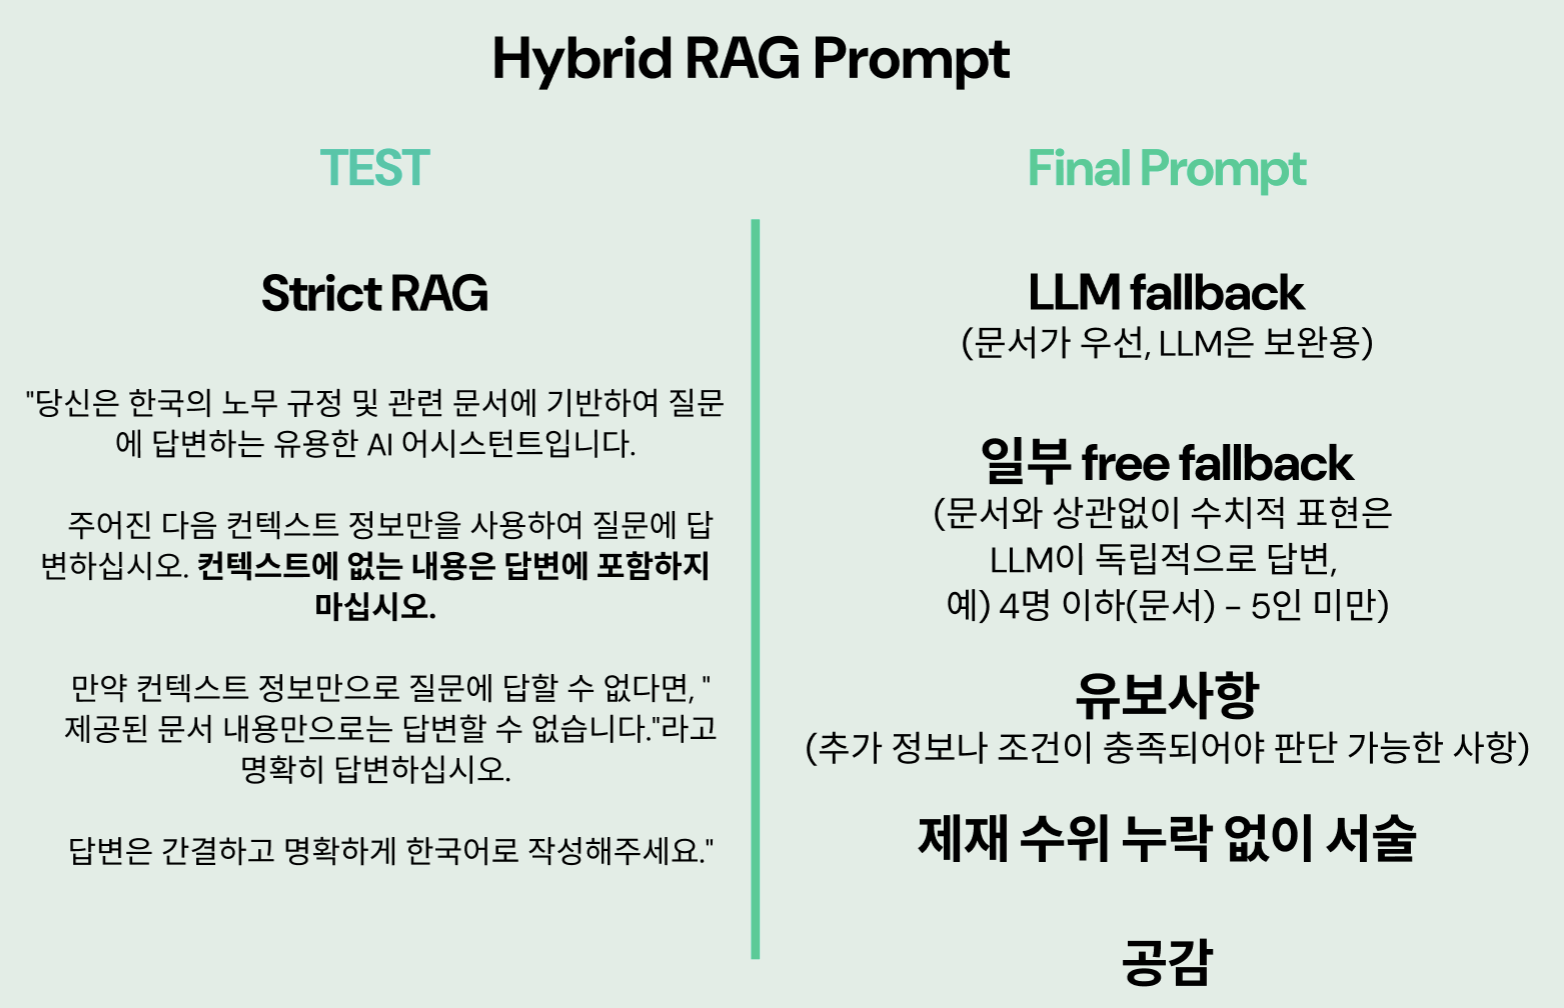

In [ ]:
# === 단계 10: RAG Chain/파이프라인 구축 ===
# (코드 변경 없음 - 단계 9에서 변경된 llm 객체를 사용)
print("\n--- 단계 10: RAG Chain 구축 시작 ---")
qa_chain = None
if llm and retriever: # llm이 ChatOpenAI 인스턴스로 준비됨
    template = """당신은 한국의 노무 규정 및 관련 문서에 기반하여 질문에 답변하는 유용한 AI 어시스턴트입니다.

[답변 방식]
- 질문자의 상황에 공감하는 짧은 인삿말 또는 격려 문장으로 시작해 주세요. (예: "육아와 일을 병행하시느라 많이 바쁘시죠?")
- 핵심 정보를 가장 먼저, 간결한 문장으로 제시해 주세요.
- 필요한 경우 예시나 조건을 덧붙여 주세요.
- 답변의 끝맺음은 "~입니다."보다는 "~이에요.", "~할 수 있어요.", "~하셔야 해요."처럼 **부드러운 종결어미 (~요)** 로 통일해 주세요.
- 법령의 의미는 일반 사용자가 이해할 수 있도록 쉽게 풀어 설명해 주세요.
- 문서에 없는 수치 표현(예: 5인 이하)이라도 의미가 동일한 경우(예: 4인 미만)로 논리적으로 해석하여 설명해 주세요.
- 질문에 대한 명확한 조항이 문서에 없더라도, 질문이 일반적이고 상식적이라면 LLM의 일반 지식을 바탕으로 신중히 보완해 주세요.
- 너무 긴 문단 없이, **가독성을 높이기 위해 2~3문장 단위로 줄을 바꿔** 주세요.
- 관련 조항이 있는 경우에는 판단을 미루지 말고, 해당 조문을 바탕으로 명확히 답변해 주세요.
- 형사처벌·벌금·과태료 조항이 문서에 명시되어 있다면 반드시 포함해 주세요.

[신뢰성 및 최신 법령 반영 조건]
- 2025년 기준 최신 개정 법령을 기반으로 답변해 주세요. (예: 육아휴직 1년 6개월)
- 위반 시 제재 수위는 "행정처분", "과태료", "형사처벌" 중 구체적으로 구분해 주세요.
- 해당 제재 조항이 문서에 없거나 명확하지 않은 경우에는 "문서만으로는 판단이 어려워요."라고 안내해 주세요.
- 법령에 명시된 경우에만 형사처벌이나 과태료 내용을 언급해 주세요.
- 해석이 분분하거나 쟁점이 있는 경우에도 "문서만으로는 판단이 어려워요."라고 안내해 주세요.
- 단정적이거나 기계적인 표현은 피하고, 부드럽고 책임감 있는 말투로 마무리해 주세요.
- 일반적인 법률 지식을 활용하되, 문서의 내용을 우선하여 신중하게 작성해 주세요.
- 질문이 일반적이고 컨텍스트에 관련 조항이 없을 경우, LLM의 일반적인 법률 지식을 기반으로 보완하되, 문서보다 우선하지 않도록 주의하십시오.
- 특히 노동 관련 법령에서 제재 수위는 핵심이므로 누락 없이 서술하십시오.

[언어 스타일]
- 기계적인 표현은 피하고, 자연스러운 설명형 문장으로 작성해 주세요.
- 문장 끝은 "~입니다."보다는 "~이에요", "~하셔야 해요", "~하실 수 있어요" 등의 부드러운 말투를 사용해 주세요.
- 예시 표현은 매번 "예를 들어"보다는 "예컨대", "보통 이런 경우", "예시를 들면" 등으로 자연스럽게 다양화해 주세요.
- 핵심 정보 → 예시 → 조건/예외 → 마무리 안내 순으로 작성해 주세요.
- 너무 긴 문단 없이 자연스럽게 문단을 나누어 주세요.
- 필요한 경우 "더 자세한 내용은 노무사 상담이나 회사 내규 확인이 필요해요."와 같이 안내해 주세요.
- 마크다운 굵은 글자 등 특수 포맷은 사용하지 말고, 일반 텍스트로 출력해 주세요.

[정리]
- 질문자가 불안하거나 혼란스러울 수 있는 상황일 경우, 짧고 자연스러운 **공감 표현**으로 답변을 시작해 주세요. (예: “이런 상황에서는 혼란스러우실 수 있어요.”)
- 단순한 사실 확인 질문일 경우에는 공감 표현 없이 바로 **핵심 정보**부터 제시해 주세요.
- 전체 답변은 다음 순서로 구성하세요:
  1. (조건부) 공감 표현 1문장
  2. 핵심 정보 요약
  3. 예시 또는 일반적인 적용 조건
  4. 제한사항 또는 유의사항
- 너무 형식적이지 않게, 대화하듯 편안하고 믿을 수 있는 말투로 설명해 주세요."


    컨텍스트:
    {context}

    질문: {question}

    답변 (한국어):"""
    QA_CHAIN_PROMPT = PromptTemplate.from_template(template)
    try:
        qa_chain = RetrievalQA.from_chain_type(
            llm=llm, # ChatOpenAI 인스턴스 사용
            chain_type="stuff",
            retriever=retriever,
            return_source_documents=True,
            chain_type_kwargs={"prompt": QA_CHAIN_PROMPT}
        )
        print("[성공] RetrievalQA Chain 구축 완료.")
    except Exception as e: print(f"!! RAG Chain 구축 실패: {e}")
else: print("!! LLM 또는 Retriever 준비 안 됨. RAG Chain 구축 불가.")
print("--- 단계 10: RAG Chain 구축 완료 ---")


--- 단계 10: RAG Chain 구축 시작 ---
[성공] RetrievalQA Chain 구축 완료.
--- 단계 10: RAG Chain 구축 완료 ---


# 테스트 코드

리트리버 가중치와 k값을 달리하며 질문에 대한 리트리버 검색 문서 빠르게 확인 가능한 테스트 코드.

확인하고자 하는 검색 문서가 언제 검색되는지 확인할 때 사용하는 코드예요.

In [ ]:
# 기존 retriever 구성 유지하고, k 값을 늘려보기
faiss_retriever.search_kwargs = {'k': 1}
bm25_retriever.k = 1
retriever = EnsembleRetriever(retrievers=[bm25_retriever, faiss_retriever], weights=[0.3, 0.7])

# 다시 질문해보기
test_question = "근로자를 해고하려면 몇일 전에 예고를 해야 하나요?"
retrieved_docs = retriever.invoke(test_question)

for i, doc in enumerate(retrieved_docs):
    print(f"\n--- 검색 문서 #{i+1} ---")
    print(doc.page_content[:500])

#11: RAG 시스템 실행 (기본적인 질의-응답)

In [ ]:
# === 단계 11: RAG 시스템 실행 (질의-응답) ===
print("\n--- 단계 11: RAG 시스템 실행 시작 ---")

from langchain.chains import RetrievalQA

# qa_llm을 사용하여 qa_chain 구성
qa_chain = RetrievalQA.from_chain_type(
    llm=qa_llm,  # 분리된 응답용 LLM 사용
    chain_type="stuff",
    retriever=retriever,
    return_source_documents=True,
    chain_type_kwargs={"prompt": QA_CHAIN_PROMPT}
)

query = None  # 결과 저장용
result = None

if qa_chain:
    query = "근로자를 해고하려면 며칠 전에 예고를 해야 하나요?"  # 테스트 질문
    print(f"\n입력 질문: {query}")
    try:
        print("답변 생성 중...")
        start_qa_time = time.time()

        result = qa_chain.invoke({"query": query})

        end_qa_time = time.time()
        print(f"답변 생성 완료 ({end_qa_time - start_qa_time:.2f}초)")

        print("\n[최종 답변]:")
        print(result.get("result", "N/A"))

        print("\n[참고 문서 (Source Documents)]:")
        source_docs = result.get("source_documents", [])
        for i, doc in enumerate(source_docs):
            print(f"\n--- 문서 {i+1} ---")
            print(doc.page_content[:300])  # 길면 잘라서 출력
            print(f"메타데이터: {doc.metadata}")
    except Exception as e:
        print(f"!! RAG Chain 실행 오류: {e}")
        traceback.print_exc()
else:
    print("!! RAG Chain 준비 안 됨. 실행 불가.")

print("\n--- 단계 11: RAG 시스템 실행 완료 ---")



--- 단계 11: RAG 시스템 실행 시작 ---

입력 질문: 근로자를 해고하려면 며칠 전에 예고를 해야 하나요?
답변 생성 중...
답변 생성 완료 (4.65초)

[최종 답변]:
해고 예고 기간이 궁금하실 수 있어요.

근로자를 해고하려면 원칙적으로 최소 30일 전에 미리 예고를 해야 해요.  
만약 30일 전에 예고하지 않았다면, 30일분 이상의 통상임금을 별도로 지급해야 해요.

다만, 근로자가 계속 근무한 기간이 3개월 미만이거나, 천재지변 등으로 사업을 계속할 수 없는 경우, 또는 근로자가 고의로 회사에 막대한 손해를 끼친 경우 등에는 예고 없이 해고할 수 있어요.

해고 예고를 하지 않거나 예외 사유에 해당하지 않는데도 예고 없이 해고하면, 사업주는 2년 이하의 징역 또는 2천만 원 이하의 벌금형을 받을 수 있으니 주의하셔야 해요.  
더 궁금한 점이 있으면 노무사 상담을 받아보시는 것도 도움이 될 거예요.

[참고 문서 (Source Documents)]:

--- 문서 1 ---
제26조(해고의 예고) 사용자는 근로자를 해고(경영상 이유에 의한 해고를 포함한다)하려면 적어도 30일 전에 예고를 하
여야 하고, 30일 전에 예고를 하지 아니하였을 때에는 30일분 이상의 통상임금을 지급하여야 한다. 다만, 다음 각 호
의 어느 하나에 해당하는 경우에는 그러하지 아니하다. <개정 2010. 6. 4., 2019. 1. 15.>
1. 근로자가 계속 근로한 기간이 3개월 미만인 경우
2. 천재ㆍ사변, 그 밖의 부득이한 사유로 사업을 계속하는 것이 불가능한 경우
3. 근로자가 고의로 사업에 막대한 지장을 초래하거나 재
메타데이터: {'producer': 'iText 2.1.7 by 1T3XT', 'creator': 'PyPDF', 'creationdate': '2025-04-01T12:35:38+09:00', 'moddate': '2025-04-01T12:35:38+09:00', 'source': '/content/drive/MyDrive/nomu_

#11-1: RAG 시스템 실행 (질의-응답) - 단일턴

본 코드는 어떤 후속질문을 생성하는지 확인할 수 있는 코드이며,
실제 챗봇에서 구현하려면, main.py, util.py 등의 벡앤드 설계를 함께 진행해야 챗봇에서 구현됨.

query = "근로자를 해고하려면 몇일 전에 예고를 해야 하나요?" # 테스트 질문

In [ ]:
# === 단계 11: RAG 시스템 실행 (질의-응답) ===
print("\n--- 단계 11: RAG 시스템 실행 시작 ---")

from langchain.chains import RetrievalQA

# === [1] 질문 분류 함수 ===
def is_statement(text: str) -> bool:
    question_keywords = ["뭐야", "뭔가요", "어떻게", "무엇", "언제", "왜", "얼마", "가능해", "되나요", "인가요", "?"]
    return not any(kw in text for kw in question_keywords)

# === [2] 질문 생성 함수 (LLM 사용) ===
def generate_followup_question(llm, statement: str) -> str:
    prompt = f"""
이 발화는 질문이 아니라 진술일 가능성이 있습니다. 법적 상담에 필요한 핵심 정보를 얻기 위해 이어서 해야 할 가장 적절한 후속 질문 하나를 자연스럽게 생성하세요.
단, 너무 포괄적인 질문(예: \"무슨 도움이 필요하세요?\")은 피하고, 구체적이고 실용적인 질문을 생성하세요.

사용자 발화: "{statement}"

후속 질문:
"""
    try:
        response = llm.invoke(prompt)
        return response.content.strip()
    except Exception as e:
        print(f"[후속 질문 생성 실패] {e}")
        return ""

# === [3] qa_chain 생성 ===
qa_chain = RetrievalQA.from_chain_type(
    llm=qa_llm,  # 분리된 응답용 LLM 사용
    chain_type="stuff",
    retriever=retriever,
    return_source_documents=True,
    chain_type_kwargs={"prompt": QA_CHAIN_PROMPT}
)

query = "나는 근로자야"  # 실제 사용자 발화 (진술)

if qa_chain:
    print(f"\n입력 질문: {query}")

    # ✅ 진술 여부 판단 및 후속 질문 생성
    if is_statement(query):
        print("➡️ 이 발화는 진술로 판단됨. 후속 질문 생성 중...")
        followup = generate_followup_question(qa_llm, query)
        if followup:
            print(f"🔁 생성된 후속 질문: {followup}")
            query = followup
        else:
            print("❌ 후속 질문 생성 실패. 원래 발화로 진행")

    try:
        print("답변 생성 중...")
        start_qa_time = time.time()

        result = qa_chain.invoke({"query": query})

        end_qa_time = time.time()
        print(f"답변 생성 완료 ({end_qa_time - start_qa_time:.2f}초)")

        print("\n[최종 답변]:")
        print(result.get("result", "N/A"))

        print("\n[참고 문서 (Source Documents)]:")
        source_docs = result.get("source_documents", [])
        for i, doc in enumerate(source_docs):
            print(f"\n--- 문서 {i+1} ---")
            print(doc.page_content[:300])
            print(f"메타데이터: {doc.metadata}")

    except Exception as e:
        print(f"!! RAG Chain 실행 오류: {e}")
        traceback.print_exc()
else:
    print("!! RAG Chain 준비 안 됨. 실행 불가.")

print("\n--- 단계 11: RAG 시스템 실행 완료 ---")



--- 단계 11: RAG 시스템 실행 시작 ---

입력 질문: 나는 근로자야
➡️ 이 발화는 진술로 판단됨. 후속 질문 생성 중...
🔁 생성된 후속 질문: 현재 어떤 근로계약 형태로 일하고 계신가요? (예: 정규직, 계약직, 아르바이트 등)
답변 생성 중...
답변 생성 완료 (4.75초)

[최종 답변]:
이런 부분은 헷갈릴 수 있어서 고민이 많으실 것 같아요.

근로기준법상 상시근로자 수 산정에서는 근로계약의 명칭이나 외형이 아니라, 실제로 사용자의 지휘·감독 아래 근로를 제공하는지 여부가 가장 중요해요.

즉, 도급제 형태로 일하더라도 실질적으로 사용자의 지휘·감독을 받으며 일한다면, 그 근로자도 상시근로자 수에 포함해야 해요.

예를 들어, 작업 시간·방법·장소 등을 사용자가 정하고, 근로자가 이에 따라 일하는 경우에는 도급계약 명칭과 상관없이 근로자로 간주돼요.

반대로, 근로자가 독립적으로 일하고 결과만 납품하는 경우라면 상시근로자 수에 포함되지 않을 수 있어요.

실제 근로형태에 따라 판단이 달라질 수 있으니, 구체적인 상황에 따라 노무사 상담을 받아보시는 것도 도움이 될 거예요.

[참고 문서 (Source Documents)]:

--- 문서 1 ---
No.: 35
question: 최근 저는 한 화장품회사와 단기간고용계약을 체결하면서 기간만을 특정하고 근로시간에 대하여는 매월 주당 평균 15시간 미만 만을 정할 뿐 구체적으로 정하지 않았습니다. 이러한 근로계약이 근로기준법에서 말하는 근로계약에 해당하나요?
answer: 아니요, 근로기준법상 근로계약은 보다 구체적이고 확정적이어야 합니다.
메타데이터: {'source': 'https://docs.google.com/spreadsheets/d/1QeMvmrcYe6QQ8L1n6o1NQ7ASTPafmzdbuDAAKXFCu3k/edit?gid=0', 'title': 'filtered_qa_dataset - Sheet1', 'row': 36, 'file_type': 'google_sheet'}

# 12. RAGAS Retriever 평가

사용할 Google Sheet 파일 이름

GSHEET_FILE_NAME = "filtered_qa_dataset"

QUESTION_COLUMN = "question"

ANSWER_COLUMN = "answer"             

GROUND_TRUTHS_COLUMN = "ground_truths"

체크포인트를 추가하여 평가하는 중 평가가 멈추더라도 평가가 끝난 시점까지의 평가 데이터는 기록되고 다시 시작하면 이어서 평가를 진행할 수 있음.


✅ RAGAS 평가지표
LLM기반으로 평가하기때문에 평가지수가 조금씩 달라짐.

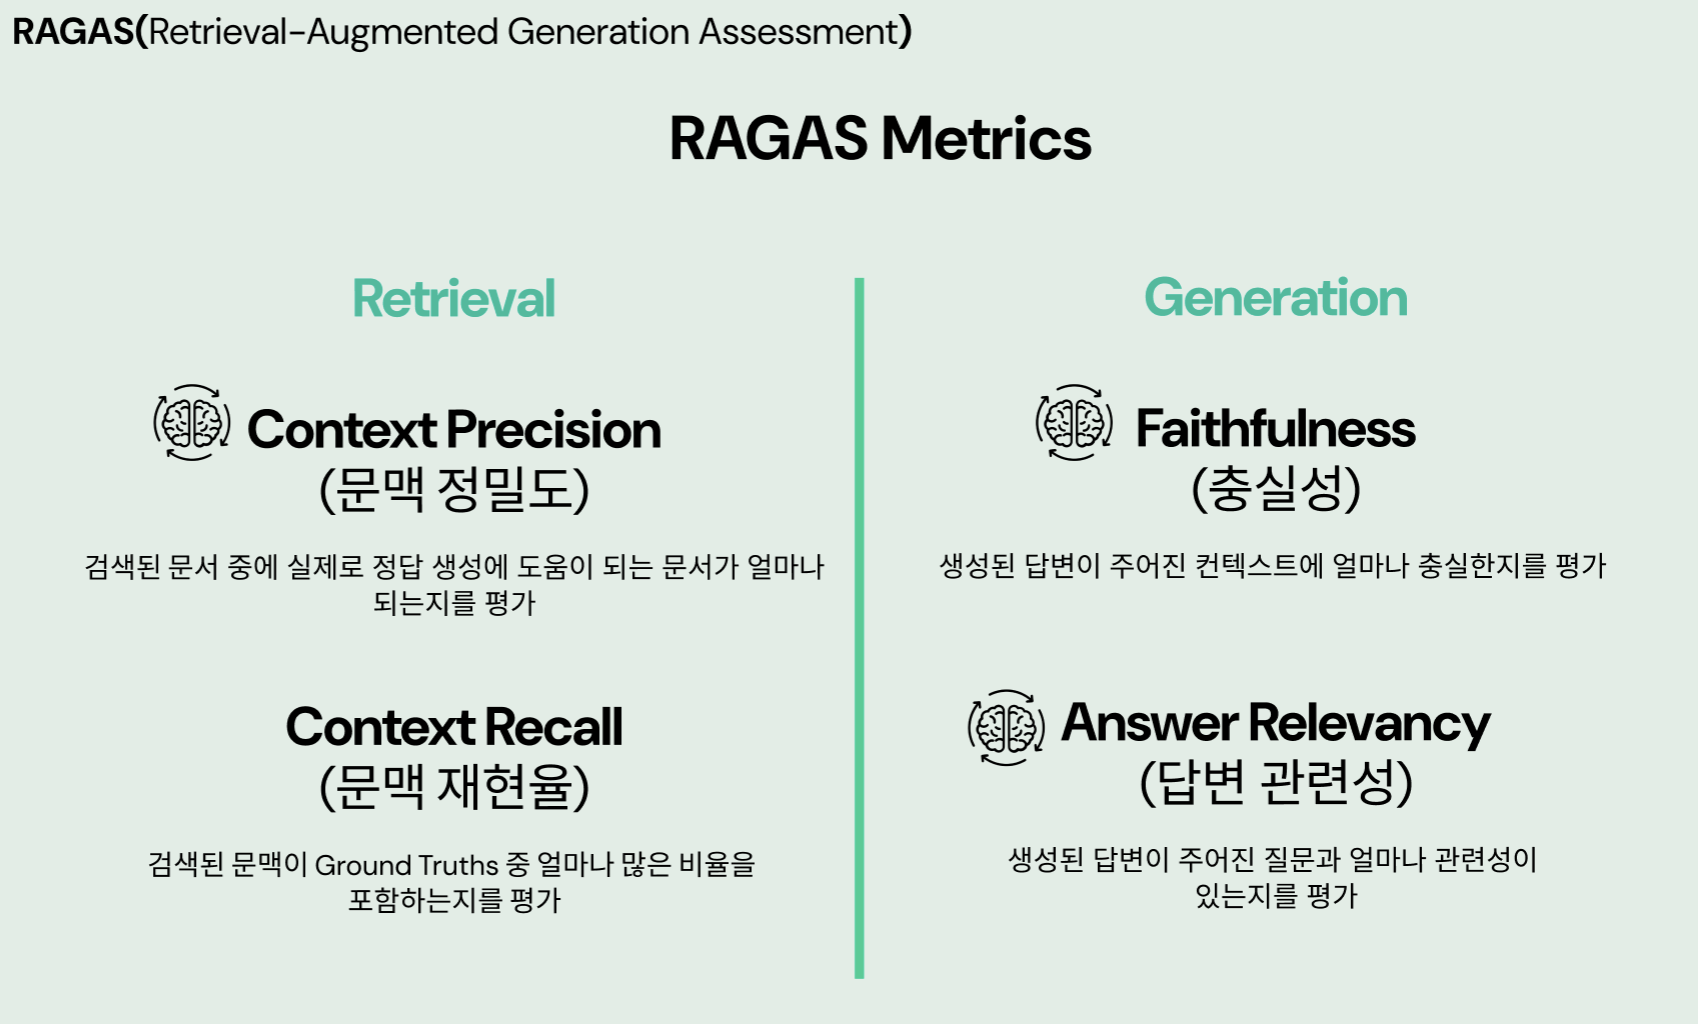


상태 저장: result_dir 아래의 ragas_eval_exec_status.json (마지막 처리 인덱스 저장)

결과 저장: result_dir 아래의 ragas_eval_exec_results_partial.csv (배치별 결과 누적 저장)

전체 경로 (예시): /content/drive/MyDrive/nomu_rag_result/ragas_eval_exec_status.json

In [ ]:
# === 단계 12: RAGAS Retriever 평가 (filtered_qa_dataset 사용) ===

# 기능:
# 1. Google Sheet ('filtered_qa_dataset')에서 평가 데이터셋 로드.
# 2. 각 'question'에 대해 Retriever를 실행하여 'contexts' 검색.
# 3. RAGAS 데이터 형식에 맞게 변환 ('question', 'contexts', 'reference', 'ground_truths').
# 4. RAGAS evaluate()를 사용하여 'context_precision' 및 'context_recall' 계산.
# 5. 결과 요약 및 출력 (배치 처리 및 시간 지연 포함).

# --- 12.0: 필요 라이브러리 임포트 및 재확인 ---
print("\n--- 단계 12: RAGAS Retriever 평가 시작 (Google Sheet 데이터 사용) ---")
import os
import pandas as pd
import gspread
import time
from tqdm.notebook import tqdm
import numpy as np
import json
import warnings
import traceback # 상세 오류 출력

# Google Colab/Auth 관련
try:
    from google.colab import auth
    print("[정보] Google Colab 환경 감지됨.")
    COLAB_ENV = True
except ImportError:
    print("[정보] Google Colab 환경 아님. 로컬 인증 가정.")
    COLAB_ENV = False
from google.auth import default as google_auth_default

# RAGAS 및 관련 라이브러리 임포트 (오류 발생 시 메시지 출력)
try:
    from datasets import Dataset
    from ragas import evaluate
    # Retriever 평가 메트릭
    from ragas.metrics import context_precision, context_recall
    # RAGAS 래퍼 클래스 (최신 버전 호환)
    from ragas.llms import LangchainLLMWrapper
    from ragas.embeddings import LangchainEmbeddingsWrapper
    print("[정보] RAGAS 및 관련 라이브러리 임포트 확인")
    RAGAS_AVAILABLE = True
except ImportError as e:
    print(f"!! [오류] RAGAS 관련 라이브러리 임포트 실패: {e}")
    print("   `ragas==0.2.15` 및 `datasets` 설치를 확인하세요.")
    Dataset = None; evaluate = None; context_precision = None; context_recall = None;
    LangchainLLMWrapper = None; LangchainEmbeddingsWrapper = None
    RAGAS_AVAILABLE = False

warnings.filterwarnings("ignore") # 경고 메시지 숨기기 (선택 사항)

# --- 12.1: Google 인증 및 gspread 클라이언트 확인 ---
print("\n--- 12.1: Google 인증 및 gspread 클라이언트 확인 ---")
gc = None # gspread 클라이언트 초기화
try:
    # Colab에서는 이전 단계 인증 사용, 로컬에서는 gcloud auth login 등 필요
    creds, _ = google_auth_default()
    gc = gspread.authorize(creds)
    print("[성공] Google 인증 및 gspread 클라이언트 준비 완료.")
except Exception as e:
    print(f"!! [실패] Google 인증 또는 gspread 클라이언트 생성 오류: {e}.")
    print("   Colab 환경이 아니거나 인증 정보가 유효하지 않을 수 있습니다.")

# --- 12.2: 필수 객체 확인 및 RAGAS 래퍼 초기화 ---
print("\n--- 12.2: 필수 객체 확인 및 RAGAS 래퍼 초기화 ---")

# 평가용 LLM, Retriever, Embeddings 객체 확인 (이전 단계에서 정의됨)
# RAGAS 평가는 eval_llm 사용 권장
llm_available = 'eval_llm' in locals() and eval_llm is not None
retriever_available = 'retriever' in locals() and retriever is not None
# Embeddings는 context_precision/recall에 직접 필요 없으나, 다른 메트릭 위해 확인
embeddings_available = 'embeddings' in locals() and embeddings is not None

ragas_llm = None
ragas_embeddings = None

if RAGAS_AVAILABLE:
    # LLM 래퍼 초기화 (평가용 eval_llm 사용)
    if llm_available:
        if LangchainLLMWrapper:
            try:
                ragas_llm = LangchainLLMWrapper(eval_llm) # 키워드 인자 없이 객체만 전달
                print(f"[성공] RAGAS LLM 래퍼 초기화 완료 (모델: {eval_llm.model_name})") # eval_llm 사용
            except Exception as e:
                print(f"!! [오류] RAGAS LLM 래퍼 초기화 실패: {e}"); llm_available = False
        else:
             print("!! Ragas LLM 래퍼 클래스 임포트 실패.")
             llm_available = False
    else:
        print("!! [오류] 평가용 LLM 객체('eval_llm')가 정의되지 않았습니다.")

    # Embedding 래퍼 초기화 (선택 사항)
    if embeddings_available:
        if LangchainEmbeddingsWrapper:
            try:
                ragas_embeddings = LangchainEmbeddingsWrapper(embeddings) # 키워드 인자 없이 객체만 전달
                print("[정보] RAGAS Embedding 래퍼 초기화 완료 (필요시 사용).")
            except Exception as e:
                print(f"!! [경고] RAGAS Embedding 래퍼 초기화 오류: {e}."); embeddings_available = False
        else:
             print("!! Ragas Embedding 래퍼 클래스 임포트 실패.")
    else:
        print("[정보] Embedding 객체('embeddings') 없음.")
else:
    print("!! RAGAS 라이브러리 임포트 실패. RAGAS 평가 불가.")

# Retriever 존재 확인
if retriever_available: print("[정보] Retriever 객체('retriever') 확인 완료.")
else: print("!! [오류] Retriever 객체('retriever') 없음. 평가 불가.")

# --- 12.3: 평가 데이터셋 로드 (Google Sheet: filtered_qa_dataset) ---
print("\n--- 12.3: 평가 데이터셋 로드 (Google Sheet) ---")
# 사용할 Google Sheet 파일 이름 및 컬럼명
GSHEET_FILE_NAME = "filtered_qa_dataset"
QUESTION_COLUMN = "question"        # 질문 컬럼
ANSWER_COLUMN = "answer"            # Ground Truth 답변 컬럼 (-> RAGAS 'reference')
GROUND_TRUTHS_COLUMN = "ground_truths" # Ground Truth 문서/구절 컬럼 (-> RAGAS 'ground_truths')

qa_df = pd.DataFrame() # 데이터 로드용 DataFrame 초기화
ground_truths_column_exists = False # context_recall 평가 가능 여부 플래그
answer_column_exists = False        # context_precision 평가 가능 여부 플래그 (reference 컬럼 생성용)

if gc: # Google Sheet 클라이언트 준비 시
    print(f"Google Sheet '{GSHEET_FILE_NAME}' 로드 시도...")
    try:
        spreadsheet = gc.open(GSHEET_FILE_NAME)
        worksheet = spreadsheet.get_worksheet(0) # 첫 번째 시트 사용
        print("  워크시트 데이터 로딩 중...")
        data = worksheet.get_all_values()
        if len(data) > 1: # 헤더 포함 최소 2줄
            qa_df = pd.DataFrame(data[1:], columns=data[0]) # 첫 행은 헤더
            print(f"  [성공] Google Sheet 로드 완료: {len(qa_df)}개 행")
            print(f"     컬럼 목록: {qa_df.columns.tolist()}")

            # 필수/선택 컬럼 확인
            if QUESTION_COLUMN not in qa_df.columns:
                raise ValueError(f"필수 컬럼 '{QUESTION_COLUMN}'이 시트에 없습니다.")
            if GROUND_TRUTHS_COLUMN in qa_df.columns:
                ground_truths_column_exists = True
                print(f"  [정보] '{GROUND_TRUTHS_COLUMN}' 컬럼 확인됨 (context_recall 평가 가능).")
            else:
                print(f"  !! [경고] '{GROUND_TRUTHS_COLUMN}' 컬럼 없음. context_recall 점수는 0이 됩니다.")
            if ANSWER_COLUMN in qa_df.columns:
                answer_column_exists = True
                print(f"  [정보] '{ANSWER_COLUMN}' 컬럼 확인됨 (context_precision 위한 'reference' 생성 가능).")
            else:
                # Context Precision은 reference(정답)가 필요하므로 경고
                print(f"  !! [경고] '{ANSWER_COLUMN}' 컬럼 없음. context_precision 평가 불가.")
        else:
            print("  !! [오류] Google Sheet에 헤더 외 데이터가 없습니다.")
            qa_df = pd.DataFrame()
    except gspread.exceptions.SpreadsheetNotFound:
        print(f"  !! [오류] Google Sheet '{GSHEET_FILE_NAME}'을(를) 찾을 수 없습니다.")
        qa_df = pd.DataFrame()
    except Exception as e:
        print(f"  !! [오류] Google Sheet 로드 중 예상치 못한 오류: {e}")
        traceback.print_exc()
        qa_df = pd.DataFrame()
else:
    print("!! Google Sheet 클라이언트(gc)가 준비되지 않아 데이터셋을 로드할 수 없습니다.")

# --- 12.4: RAGAS 평가 데이터 준비 (Retriever 실행 포함) ---
print("\n--- 12.4: RAGAS 평가 데이터 준비 ---")
eval_data_list = []
# DataFrame이 비어있고, Retriever 준비되었을 때만 진행
if not qa_df.empty and retriever_available:
    print(f"총 {len(qa_df)}개 질문에 대해 Contexts 검색 및 RAGAS 형식 변환 중...")
    for index, row in tqdm(qa_df.iterrows(), total=qa_df.shape[0], desc="RAGAS 데이터 준비"):
        question_text = row.get(QUESTION_COLUMN)
        if pd.isna(question_text) or not str(question_text).strip():
            continue # 질문 없으면 건너<0xEB><0x9B><0x81>기
        question_text = str(question_text).strip()

        # Ground Truth Answer (for context_precision -> 'reference')
        reference_text = str(row.get(ANSWER_COLUMN, "")).strip() if answer_column_exists else ""

        # Ground Truth Documents/Passages (for context_recall -> 'ground_truths')
        ground_truths_input = row.get(GROUND_TRUTHS_COLUMN, "[]") if ground_truths_column_exists else "[]"
        ground_truths_list = [] # RAGAS 'ground_truths'용 리스트

        retrieved_contexts = [] # RAGAS 'contexts'용 리스트

        try:
            # 1. Ground Truths (문서/구절) 파싱
            if ground_truths_column_exists and isinstance(ground_truths_input, str) and ground_truths_input.strip():
                try:
                    parsed_list = json.loads(ground_truths_input) # JSON 배열 "[...]" 형식 가정
                    if isinstance(parsed_list, list):
                        ground_truths_list = [str(item).strip() for item in parsed_list if item is not None and str(item).strip()]
                    else: # JSON 파싱은 됐으나 리스트 아님
                         ground_truths_list = [ground_truths_input.strip()] # 원본 문자열 사용
                except (json.JSONDecodeError, TypeError): # JSON 파싱 실패 시
                    ground_truths_list = [ground_truths_input.strip()] # 원본 문자열 사용
            elif isinstance(ground_truths_input, list): # 이미 리스트 형태인 경우
                 ground_truths_list = [str(item).strip() for item in ground_truths_input if item is not None and str(item).strip()]

            # 2. Retriever 실행하여 Contexts 검색
            retrieved_docs = retriever.invoke(question_text)
            retrieved_contexts = [doc.page_content for doc in retrieved_docs]

            # 3. RAGAS 평가 데이터 형식으로 구성
            eval_item = {
                "question": question_text,         # 질문
                "contexts": retrieved_contexts,    # 검색된 문서 내용 리스트
                "reference": reference_text,       # Ground Truth 답변 (ANSWER_COLUMN 값)
                "ground_truths": [ground_truths_list] # Ground Truth 문서/구절 리스트 (주의: 리스트의 리스트 형태)
                # Ragas 0.1.x에서 context_recall은 ground_truths 컬럼이 List[List[str]] 형태를 기대함
            }
            eval_data_list.append(eval_item)

        except Exception as e:
            print(f"\n!! 데이터 준비 중 오류 (질문 #{index}: '{question_text[:50]}...'): {e}")
            traceback.print_exc()
            # 오류 발생 시 빈 데이터 추가는 피하거나, 필요한 최소 정보만 넣어 에러 방지
            # eval_data_list.append({"question": question_text, "contexts": [], "reference": "", "ground_truths": [[]]})

    print(f"[완료] RAGAS 평가용 데이터 {len(eval_data_list)}개 준비 완료.")
else:
    if qa_df.empty: print("!! 평가 데이터(qa_df)가 비어있거나 로드되지 않아 데이터 준비 불가.")
    if not retriever_available: print("!! Retriever가 없어 Contexts를 검색할 수 없으므로 데이터 준비 불가.")

# --- 12.5: Hugging Face Dataset 형식으로 변환 ---
print("\n--- 12.5: Hugging Face Dataset 변환 ---")
eval_dataset = None
if eval_data_list and Dataset: # Dataset 클래스 로드 성공 시
    try:
        eval_dataset = Dataset.from_list(eval_data_list)
        print("[성공] Hugging Face Dataset으로 변환 완료.")
        print(f"   데이터셋 컬럼: {eval_dataset.column_names}")
        # 생성된 컬럼 확인 (context_precision, context_recall에 필요한 컬럼 포함 여부)
        required_eval_cols = {'question', 'contexts', 'reference', 'ground_truths'}
        if not required_eval_cols.issubset(eval_dataset.column_names):
             print(f"   !! [경고] 데이터셋에 RAGAS 평가 필수 컬럼 일부 누락! 필요: {required_eval_cols}")
        # 샘플 데이터 확인 (처음 1개)
        if len(eval_dataset) > 0:
            print("\n   데이터셋 샘플 (첫 번째 항목):")
            sample_item = eval_dataset[0]
            for key, value in sample_item.items():
                 print(f"     {key}: ", end="")
                 preview_limit = 100 # 미리보기 글자 수
                 if isinstance(value, list):
                     preview = str(value)[:preview_limit] + ('...' if len(str(value)) > preview_limit else '')
                     print(f"(List, {len(value)} items) {preview}")
                 else:
                     preview = str(value)[:preview_limit] + ('...' if len(str(value)) > preview_limit else '')
                     print(f"{preview}")

    except Exception as e:
        print(f"!! [오류] Dataset 변환 중 오류: {e}"); traceback.print_exc(); eval_dataset = None
else:
    print("!! [정보] 생성된 평가 데이터가 없거나 Dataset 클래스 로드 실패하여 변환 불가.")

# --- 12.6: RAGAS 평가 실행 (배치 처리 및 시간 지연 추가) ---
print("\n--- 12.6: RAGAS 평가 실행 (배치 처리 및 시간 지연 추가) ---")
evaluation_results_df = None # 평가 결과 저장 DataFrame 초기화
all_results_list = [] # 배치 결과 누적용 리스트
eval_batch_size = 10   # ===> 배치 크기 설정 (API 제한, 리소스 고려하여 조절) <===
seconds_to_wait_between_batches = 5 # ===> 배치 간 대기 시간 (초) <===
# seconds_to_wait_on_error = 30    # ===> 오류 발생 시 다음 배치 전 대기 시간 (초) <===

# 평가 실행 조건 확인
evaluation_possible = (
    RAGAS_AVAILABLE and
    llm_available and ragas_llm is not None and # LLM 및 RAGAS 래퍼 준비
    retriever_available and                     # Retriever 준비 (Context 생성용)
    eval_dataset and                            # Dataset 준비
    evaluate and context_precision and context_recall # Ragas 함수/메트릭 확인
)

if evaluation_possible:
    # 사용할 평가 지표 정의 (데이터 준비 상태에 따라 결정)
    metrics_to_evaluate = []
    if context_precision and answer_column_exists: # 'reference' 생성 가능 시
        metrics_to_evaluate.append(context_precision)
    if context_recall and ground_truths_column_exists: # 'ground_truths' 준비 가능 시
        metrics_to_evaluate.append(context_recall)

    if not metrics_to_evaluate:
        print("!! [오류] 평가할 유효한 RAGAS 메트릭이 없습니다 (데이터 컬럼 부족 가능성).")
        print(f"   (Answer 컬럼 존재: {answer_column_exists}, GroundTruths 컬럼 존재: {ground_truths_column_exists})")
    else:
        print(f"평가 지표: {[m.name for m in metrics_to_evaluate]}")
        print(f"총 {len(eval_dataset)}개 항목을 {eval_batch_size}개씩 배치 처리...")

        overall_progress = tqdm(total=len(eval_dataset), desc="전체 평가 진행률")

        # 배치 처리 루프
        for i in range(0, len(eval_dataset), eval_batch_size):
            batch_start_index = i
            batch_end_index = min(i + eval_batch_size, len(eval_dataset))
            print(f"\n--- 배치 처리 시작: 인덱스 {batch_start_index} ~ {batch_end_index - 1} ---")
            # 현재 배치 데이터셋 선택
            batch_dataset = eval_dataset.select(range(batch_start_index, batch_end_index))

            if len(batch_dataset) == 0:
                 print("  [정보] 현재 배치가 비어있어 건너<0xEB><0x9B><0x81>니다.")
                 continue

            try:
                # RAGAS 평가 실행
                print(f"  RAGAS evaluate() 호출 (배치 크기: {len(batch_dataset)})...")
                eval_start_time = time.time()
                # 대신 Dataset 크기 또는 내부 구현에 따라 처리됨.
                batch_result = evaluate(
                    dataset=batch_dataset,           # 현재 배치 데이터셋
                    metrics=metrics_to_evaluate,    # 평가 지표 리스트
                    llm=ragas_llm,                  # Ragas LLM 래퍼
                    embeddings=ragas_embeddings if embeddings_available else None # 필요시 전달
                    # raise_exceptions=False # 오류 발생 시 NaN 반환 (기본값)
                )
                eval_end_time = time.time()
                print(f"  RAGAS evaluate() 실행 시간: {eval_end_time - eval_start_time:.2f}초")

                # 결과 처리 및 누적
                if batch_result:
                    # Ragas 결과는 Dataset 객체일 수 있음 -> DataFrame 변환
                    try:
                        batch_result_df = batch_result.to_pandas()
                        print(f"  배치 평가 완료. 결과 {len(batch_result_df)}개 행 생성.")
                        all_results_list.extend(batch_result_df.to_dict('records')) # 결과 누적
                    except AttributeError:
                        print("!! 배치 결과가 Pandas DataFrame으로 변환 불가. Raw 결과 저장 시도.")
                        # 결과가 딕셔너리 등 다른 형태일 경우 처리 (덜 일반적)
                        if isinstance(batch_result, dict):
                            # 딕셔너리 결과를 리스트에 맞게 변환 필요
                             print("결과가 딕셔너리 형태입니다. 처리 방식 확인 필요.")
                             # 예시: all_results_list.append(batch_result) 또는 변환 로직
                        else: print(f"처리할 수 없는 결과 타입: {type(batch_result)}")
                    except Exception as e_conv: print(f"!! 결과 변환/저장 중 오류: {e_conv}")

                    overall_progress.update(len(batch_dataset)) # 성공 시 진행률 업데이트
                else:
                    print("!! 배치 평가 결과가 비어있습니다 (None 또는 빈 객체).")
                    overall_progress.update(len(batch_dataset)) # 결과 없어도 처리한 것으로 간주

                # API Rate Limit 방지 위한 대기 (마지막 배치 제외)
                if batch_end_index < len(eval_dataset):
                    print(f"\n  정상 처리 완료. 다음 배치를 위해 {seconds_to_wait_between_batches}초 대기...")
                    time.sleep(seconds_to_wait_between_batches)

            except Exception as e:
                print(f"!! [오류] 배치 {batch_start_index}~{batch_end_index-1} RAGAS 평가 중 심각한 오류 발생: {e}")
                print("   다음 배치로 넘어갑니다. API 할당량, 네트워크, 입력 데이터 형식 등을 확인하세요.")
                traceback.print_exc()
                overall_progress.update(len(batch_dataset)) # 오류 발생 시에도 해당 배치 처리한 것으로 간주
                # 오류 시 대기 (마지막 배치 제외)
                if batch_end_index < len(eval_dataset):
                     print(f"  오류 발생. 다음 배치를 위해 {seconds_to_wait_on_error}초 대기...")
                     time.sleep(seconds_to_wait_on_error)

        overall_progress.close() # 전체 진행률 표시 완료

        # 최종 결과 통합
        if all_results_list:
            try:
                evaluation_results_df = pd.DataFrame(all_results_list)
                print(f"\n[성공] 전체 {len(evaluation_results_df)}개 항목에 대한 RAGAS 평가 결과 통합 완료.")
                # (선택) 최종 결과 파일 저장
                if 'result_dir' in locals() and result_dir and os.path.isdir(result_dir):
                    final_results_file = os.path.join(result_dir, "ragas_eval_retriever_results_final.csv")
                    evaluation_results_df.to_csv(final_results_file, index=False, encoding='utf-8-sig')
                    print(f"  최종 결과가 '{os.path.basename(final_results_file)}'에 저장되었습니다.")
            except Exception as df_e:
                 print(f"!! 최종 DataFrame 생성 또는 저장 중 오류: {df_e}")
        else:
            print("\n[정보] 처리된 결과가 없어 최종 DataFrame을 생성할 수 없습니다.")

else:
    # 평가 실행 불가 사유 요약
    missing_components = []
    if not RAGAS_AVAILABLE: missing_components.append("RAGAS 라이브러리")
    if not llm_available: missing_components.append("LLM/RAGAS 래퍼")
    if not retriever_available: missing_components.append("Retriever")
    if not eval_dataset: missing_components.append("평가 데이터셋")
    if not (evaluate and context_precision and context_recall): missing_components.append("RAGAS 함수/메트릭")
    print(f"!! {', '.join(missing_components)} 준비 안 됨. RAGAS 평가 불가.")

# --- 12.7: 전체 평가 결과 요약 ---
print("\n--- 12.7: RAGAS Retriever 전체 평가 결과 요약 ---")
if evaluation_results_df is not None and not evaluation_results_df.empty:
    # 실제로 평가된 메트릭 컬럼만 사용
    evaluated_metrics = [m.name for m in metrics_to_evaluate if m and m.name in evaluation_results_df.columns]
    if evaluated_metrics:
        print("\n=== 전체 결과 (요약) ===")
        # NaN 값을 'NaN' 문자열로 표시하며 출력
        print(evaluation_results_df[evaluated_metrics].round(4).to_string(na_rep='NaN'))

        print("\n=== 지표별 통계 (NaN 제외) ===")
        # describe()는 기본적으로 NaN 제외
        stats = evaluation_results_df[evaluated_metrics].describe().round(4)
        print(stats)

        # NaN 발생 현황 집계
        nan_counts = evaluation_results_df[evaluated_metrics].isna().sum()
        if nan_counts.sum() > 0:
             print("\n[참고] NaN 발생 현황:")
             print(nan_counts[nan_counts > 0])
             print("  (LLM 응답 오류, Timeout, 데이터 부족 등으로 점수 계산 불가 시 발생)")
        else:
            print("\n[정보] 모든 유효 항목에 대해 점수가 성공적으로 계산되었습니다.")
    else:
        print("\n!! 평가 결과 DataFrame에 요약할 유효한 메트릭 컬럼이 없습니다.")

    # 컬럼 매핑 정보 제공
    print(f"\n**참고:**")
    if 'context_recall' in evaluated_metrics: print(f"  - 'context_recall'은(는) Google Sheet '{GROUND_TRUTHS_COLUMN}' 컬럼을 참조했습니다.")
    if 'context_precision' in evaluated_metrics: print(f"  - 'context_precision'은(는) Google Sheet '{ANSWER_COLUMN}' 컬럼 (-> 'reference')을 참조했습니다.")

else:
    print("RAGAS 평가가 실행되지 않았거나 오류가 발생하여 요약할 결과가 없습니다.")

print("\n--- 단계 12: Retriever 성능 평가 (RAGAS, Google Sheet) 완료 ---")


--- 단계 12: RAGAS Retriever 평가 시작 (Google Sheet 데이터 사용) ---
[정보] Google Colab 환경 감지됨.
[정보] RAGAS 및 관련 라이브러리 임포트 확인

--- 12.1: Google 인증 및 gspread 클라이언트 확인 ---
[성공] Google 인증 및 gspread 클라이언트 준비 완료.

--- 12.2: 필수 객체 확인 및 RAGAS 래퍼 초기화 ---
[성공] RAGAS LLM 래퍼 초기화 완료 (모델: gpt-4.1-nano)
[정보] RAGAS Embedding 래퍼 초기화 완료 (필요시 사용).
[정보] Retriever 객체('retriever') 확인 완료.

--- 12.3: 평가 데이터셋 로드 (Google Sheet) ---
Google Sheet 'filtered_qa_dataset' 로드 시도...
  워크시트 데이터 로딩 중...
  [성공] Google Sheet 로드 완료: 89개 행
     컬럼 목록: ['No.', 'question', 'answer', 'ground_truths']
  [정보] 'ground_truths' 컬럼 확인됨 (context_recall 평가 가능).
  [정보] 'answer' 컬럼 확인됨 (context_precision 위한 'reference' 생성 가능).

--- 12.4: RAGAS 평가 데이터 준비 ---
총 89개 질문에 대해 Contexts 검색 및 RAGAS 형식 변환 중...


RAGAS 데이터 준비:   0%|          | 0/89 [00:00<?, ?it/s]

[완료] RAGAS 평가용 데이터 89개 준비 완료.

--- 12.5: Hugging Face Dataset 변환 ---
[성공] Hugging Face Dataset으로 변환 완료.
   데이터셋 컬럼: ['question', 'contexts', 'reference', 'ground_truths']

   데이터셋 샘플 (첫 번째 항목):
     question: 근로계약이 미성년자에게 불리하다고 인정되는 경우 미성년후견인은 그 계약을 해지할 수 있나요?
     contexts: (List, 6 items) ['No.: 0\nquestion: 근로계약이 미성년자에게 불리하다고 인정되는 경우 미성년후견인은 그 계약을 해지할 수 있나요?\nanswer: 네. 근로계약을 해지할 수 있습니다...
     reference: 네. 근로계약을 해지할 수 있습니다.
     ground_truths: (List, 1 items) [['["「근로기준법」 제67조 제2항은 친권자,후견인 또는 고용노동부장관은 근로계약이 미성년자에게 불리하다고 인정하는 경우에는 이를 해지할 수 있다."라고 규정하고 있습니다."]...

--- 12.6: RAGAS 평가 실행 (배치 처리 및 시간 지연 추가) ---
평가 지표: ['context_precision', 'context_recall']
총 89개 항목을 10개씩 배치 처리...


전체 평가 진행률:   0%|          | 0/89 [00:00<?, ?it/s]


--- 배치 처리 시작: 인덱스 0 ~ 9 ---
  RAGAS evaluate() 호출 (배치 크기: 10)...


Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

  RAGAS evaluate() 실행 시간: 11.48초
  배치 평가 완료. 결과 10개 행 생성.

  정상 처리 완료. 다음 배치를 위해 5초 대기...

--- 배치 처리 시작: 인덱스 10 ~ 19 ---
  RAGAS evaluate() 호출 (배치 크기: 10)...


Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

  RAGAS evaluate() 실행 시간: 10.74초
  배치 평가 완료. 결과 10개 행 생성.

  정상 처리 완료. 다음 배치를 위해 5초 대기...

--- 배치 처리 시작: 인덱스 20 ~ 29 ---
  RAGAS evaluate() 호출 (배치 크기: 10)...


Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

  RAGAS evaluate() 실행 시간: 14.61초
  배치 평가 완료. 결과 10개 행 생성.

  정상 처리 완료. 다음 배치를 위해 5초 대기...

--- 배치 처리 시작: 인덱스 30 ~ 39 ---
  RAGAS evaluate() 호출 (배치 크기: 10)...


Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

  RAGAS evaluate() 실행 시간: 9.79초
  배치 평가 완료. 결과 10개 행 생성.

  정상 처리 완료. 다음 배치를 위해 5초 대기...

--- 배치 처리 시작: 인덱스 40 ~ 49 ---
  RAGAS evaluate() 호출 (배치 크기: 10)...


Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

  RAGAS evaluate() 실행 시간: 10.82초
  배치 평가 완료. 결과 10개 행 생성.

  정상 처리 완료. 다음 배치를 위해 5초 대기...

--- 배치 처리 시작: 인덱스 50 ~ 59 ---
  RAGAS evaluate() 호출 (배치 크기: 10)...


Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

  RAGAS evaluate() 실행 시간: 20.05초
  배치 평가 완료. 결과 10개 행 생성.

  정상 처리 완료. 다음 배치를 위해 5초 대기...

--- 배치 처리 시작: 인덱스 60 ~ 69 ---
  RAGAS evaluate() 호출 (배치 크기: 10)...


Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

  RAGAS evaluate() 실행 시간: 16.20초
  배치 평가 완료. 결과 10개 행 생성.

  정상 처리 완료. 다음 배치를 위해 5초 대기...

--- 배치 처리 시작: 인덱스 70 ~ 79 ---
  RAGAS evaluate() 호출 (배치 크기: 10)...


Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

  RAGAS evaluate() 실행 시간: 10.02초
  배치 평가 완료. 결과 10개 행 생성.

  정상 처리 완료. 다음 배치를 위해 5초 대기...

--- 배치 처리 시작: 인덱스 80 ~ 88 ---
  RAGAS evaluate() 호출 (배치 크기: 9)...


Evaluating:   0%|          | 0/18 [00:00<?, ?it/s]

  RAGAS evaluate() 실행 시간: 9.06초
  배치 평가 완료. 결과 9개 행 생성.

[성공] 전체 89개 항목에 대한 RAGAS 평가 결과 통합 완료.
  최종 결과가 'ragas_eval_retriever_results_final.csv'에 저장되었습니다.

--- 12.7: RAGAS Retriever 전체 평가 결과 요약 ---

=== 전체 결과 (요약) ===
    context_precision  context_recall
0              0.9167          1.0000
1              1.0000          1.0000
2              0.8333          1.0000
3              1.0000          1.0000
4              0.8333          1.0000
5              0.9667          1.0000
6              1.0000          1.0000
7              1.0000          1.0000
8              1.0000          1.0000
9              0.4167          1.0000
10             0.8056          1.0000
11             0.8042          1.0000
12             1.0000          1.0000
13             1.0000          1.0000
14             1.0000          1.0000
15             1.0000          1.0000
16             0.7500          1.0000
17             1.0000          1.0000
18             1.0000          1.0000
19             1.0000 

# 13: RAGAS 생성된 답변 평가

In [ ]:
# === 단계 13: RAGAS 평가 (생성된 답변 대상) ===
# 이 블록은 단계 11에서 RAG 시스템 실행(qa_chain.invoke) 후 실행해야 합니다.

print("\n--- 단계 12: RAGAS 평가 시작 (Faithfulness, Answer Relevancy) ---")

# 필요한 라이브러리 임포트 (이전 블록에서 임포트했더라도 명시적으로 다시 확인)
import warnings
from datasets import Dataset
# RAGAS 관련 임포트 (오류 발생 시 메시지 출력하며 None으로 설정)
try:
    from ragas import evaluate
    from ragas.metrics import faithfulness, answer_relevancy
    from ragas.llms import LangchainLLMWrapper
    from ragas.embeddings import LangchainEmbeddingsWrapper
    print("[정보] RAGAS 및 관련 라이브러리 임포트 확인.")
except ImportError as e:
    print(f"!! [오류] RAGAS 관련 라이브러리 임포트 실패: {e}")
    print("   이전 단계의 라이브러리 설치가 성공했는지, 런타임 재시작이 필요한지 확인하세요.")
    evaluate = None; faithfulness = None; answer_relevancy = None;
    LangchainLLMWrapper = None; LangchainEmbeddingsWrapper = None

warnings.filterwarnings("ignore") # 경고 메시지 숨기기

# --- 13.1: 평가에 필요한 객체 및 데이터 확인 ---
print("\n--- 12.1: 평가 필요 객체 확인 ---")

# 이전 단계(Step 11)에서 생성된 결과 확인
rag_execution_successful = ('query' in locals() and query and
                           'result' in locals() and isinstance(result, dict) and
                           'result' in result and 'source_documents' in result)

# 평가에 필요한 LLM 및 Embedding 모델 확인 (이전 단계에서 정의됨)
llm_available = 'llm' in locals() and llm is not None
embeddings_available = 'embeddings' in locals() and embeddings is not None

if not rag_execution_successful:
    print("!! [오류] 이전 단계(단계 11)의 RAG 실행 결과('query', 'result') 없음. 평가 불가.")
if not llm_available:
    print("!! [오류] 평가용 LLM 객체('llm') 없음. 평가 불가.")
if not embeddings_available:
    print("!! [경고] 평가용 Embedding 객체('embeddings') 없음. 'answer_relevancy' 계산 불가.")

# 모든 필수 요소가 준비되었는지 최종 확인
ready_for_evaluation = (rag_execution_successful and llm_available and embeddings_available and
                        evaluate and faithfulness and answer_relevancy and
                        LangchainLLMWrapper and LangchainEmbeddingsWrapper) # RAGAS 함수/클래스 임포트 확인

# --- 13.2: RAGAS 평가 데이터 준비 ---
eval_dataset = None
if ready_for_evaluation:
    print("\n--- 12.2: RAGAS 평가 데이터 준비 ---")
    try:
        # Step 11의 결과를 RAGAS가 요구하는 형식으로 변환
        eval_data = {
            'question': [query],  # Step 11의 질문 (리스트 형태)
            'answer': [result['result']], # Step 11의 생성된 답변 (리스트 형태)
            'contexts': [[doc.page_content for doc in result['source_documents']]], # 검색된 문서 내용 리스트 (리스트의 리스트 형태)
            # 'ground_truth': ["여기에 이상적인 정답 문자열을 넣을 수 있습니다"] # (선택 사항) 만약 이상적인 정답이 있다면 추가
        }
        eval_dataset = Dataset.from_dict(eval_data)
        print("[성공] 평가용 데이터셋 생성 완료 (1개 항목).")
        # print("  샘플 데이터:", eval_dataset[0]) # 디버깅용
    except Exception as e:
        print(f"!! [오류] 평가 데이터셋 생성 중 오류: {e}")
        eval_dataset = None
        ready_for_evaluation = False # 데이터 준비 실패 시 평가 불가

# --- 13.3: RAGAS 평가 실행 ---
evaluation_results = None
if ready_for_evaluation:
    print("\n--- 12.3: RAGAS 평가 실행 ---")
    try:
        # RAGAS Metric 정의 (이 평가에서는 답변 품질 지표만 사용)
        metrics_to_evaluate = [
            faithfulness,     # 답변이 컨텍스트에 얼마나 충실한가 (LLM 필요)
            answer_relevancy  # 답변이 질문과 얼마나 관련 있는가 (LLM 및 Embeddings 필요)
        ]
        print(f"평가 지표: {[m.name for m in metrics_to_evaluate]}")

        # RAGAS 래퍼 초기화 (이전 Ragas 평가 블록과 유사)
        # LLM 래퍼
        ragas_llm_eval = LangchainLLMWrapper(llm)
        # Embedding 래퍼
        ragas_embeddings_eval = LangchainEmbeddingsWrapper(embeddings)

        # 평가 실행
        print("RAGAS 평가 실행 중...")
        evaluation_results = evaluate(
            dataset=eval_dataset,
            metrics=metrics_to_evaluate,
            llm=ragas_llm_eval,
            embeddings=ragas_embeddings_eval # answer_relevancy에 필요
            # is_async=False # Colab 등에서 동시성 문제 발생 시 False 시도
        )
        print("[성공] RAGAS 평가 완료.")

    except Exception as e:
        print(f"!! [오류] RAGAS 평가 실행 중 오류 발생: {e}")
        print("   - API 키 유효성, 할당량(Rate Limit), 네트워크 연결 확인 필요.")
        print("   - LLM/Embedding 모델 호환성 또는 RAGAS 버전 문제일 수 있음.")
        traceback.print_exc() # 상세 오류 스택 출력
        evaluation_results = None
else:
    print("\n!! 필수 요소 부족으로 RAGAS 평가를 건너<0xEB><0x9B><0x81>니다.")


# --- 13.4: 평가 결과 출력 ---
print("\n--- 12.4: RAGAS 평가 결과 ---")
if evaluation_results:
    # Ragas 결과는 딕셔너리 형태일 수 있음 (최신 버전 확인 필요)
    if isinstance(evaluation_results, dict):
        print("{")
        for metric_name, score in evaluation_results.items():
             # NaN 값 처리 추가
             score_str = f"{score:.4f}" if isinstance(score, (int, float)) and not np.isnan(score) else "NaN"
             print(f"  '{metric_name}': {score_str},")
        print("}")
    else:
         # DataFrame 등으로 반환될 경우 처리
         print(evaluation_results)

    print("\n**지표 설명:**")
    print("  - faithfulness: 답변이 제공된 컨텍스트 문서 내용에 얼마나 기반하는지 (높을수록 좋음,幻覺 적음)")
    print("  - answer_relevancy: 생성된 답변이 원본 질문과 얼마나 관련성이 높은지 (높을수록 좋음)")
else:
    print("평가 결과가 없습니다.")

print("\n--- 단계 12: RAGAS 평가 완료 ---")


--- 단계 12: RAGAS 평가 시작 (Faithfulness, Answer Relevancy) ---
[정보] RAGAS 및 관련 라이브러리 임포트 확인.

--- 12.1: 평가 필요 객체 확인 ---

--- 12.2: RAGAS 평가 데이터 준비 ---
[성공] 평가용 데이터셋 생성 완료 (1개 항목).

--- 12.3: RAGAS 평가 실행 ---
평가 지표: ['faithfulness', 'answer_relevancy']
RAGAS 평가 실행 중...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

[성공] RAGAS 평가 완료.

--- 12.4: RAGAS 평가 결과 ---
{'faithfulness': 0.7500, 'answer_relevancy': 0.0000}

**지표 설명:**
  - faithfulness: 답변이 제공된 컨텍스트 문서 내용에 얼마나 기반하는지 (높을수록 좋음,幻覺 적음)
  - answer_relevancy: 생성된 답변이 원본 질문과 얼마나 관련성이 높은지 (높을수록 좋음)

--- 단계 12: RAGAS 평가 완료 ---


# 14: 정성적 평가 (LLM-as-Judge)

In [ ]:
# -*- coding: utf-8 -*-
# === 단계 14: 정성적 평가 (LLM-as-Judge) ===
# (ChatOpenAI 사용에 맞게 수정됨)

# 이 블록은 단계 11에서 RAG 시스템 실행(qa_chain.invoke 또는 __call__) 후 실행해야 합니다.

print("\n--- 단계 14: 정성적 평가 (LLM-as-Judge) 시작 ---") # <<< 단계 번호 수정

# --- 14.1: 필요한 라이브러리 및 객체 확인 ---
print("\n--- 14.1: 필요한 라이브러리 및 객체 확인 ---") # <<< 단계 번호 수정
import json
import traceback
import re # JSON 추출 위해 임포트 추가
# LangChain 관련 (이미 임포트 되었을 가능성 높음, 확인 차원)
try: from langchain.prompts import PromptTemplate
except ImportError: print("!! [오류] langchain.prompts 임포트 실패")
# LLM 클래스 확인 (ChatOpenAI)
try: from langchain_openai import ChatOpenAI
except ImportError: print("!! [오류] langchain_openai.ChatOpenAI 임포트 실패")

# 이전 단계 결과 확인
rag_execution_successful = ('query' in locals() and query and
                           'result' in locals() and isinstance(result, dict) and
                           'result' in result and 'source_documents' in result)
# 평가자 LLM 확인 (단계 9에서 정의된 llm 사용)
llm_available = 'llm' in locals() and llm is not None and isinstance(llm, ChatOpenAI) # 타입 확인 추가

if not rag_execution_successful:
    print("!! [오류] 이전 단계(단계 11)의 RAG 실행 결과('query', 'result') 없음. 평가 불가.")
if not llm_available:
    print("!! [오류] 평가용 LLM 객체('llm')가 없거나 ChatOpenAI 타입이 아님. 평가 불가.")

# --- 14.2: 평가 실행 ---
print("\n--- 14.2: 평가 실행 ---") # <<< 단계 번호 수정
if rag_execution_successful and llm_available:
    # 평가에 사용할 LLM (기존 llm 사용)
    evaluator_llm = llm
    # 만약 다른 강력한 모델을 쓰고 싶다면 여기서 재정의
    # evaluator_llm = ChatOpenAI(model="gpt-4o", temperature=0)

    # ====> 수정된 부분: .model 대신 .model_name 사용 <====
    print(f"[정보] 평가자 LLM: {evaluator_llm.model_name}")
    # ===============================================

    # 평가 데이터 추출
    rag_answer = result.get("result", "")
    source_docs = result.get("source_documents", []) # source_documents가 없다면 이전 단계 문제
    if not source_docs:
         print("!! [경고] result 객체에 'source_documents'가 비어있거나 없습니다. 컨텍스트 없는 평가 진행.")
         context_str = "" # 컨텍스트 없이 진행
    else:
         context_str = "\n\n".join([doc.page_content for doc in source_docs])

    # 평가 프롬프트 템플릿 (기존 유지)
    evaluation_template = """당신은 AI 응답 품질 평가 전문가입니다. 주어진 '질문', '컨텍스트 문서', 그리고 AI가 생성한 '답변'을 바탕으로 다음 기준에 따라 답변의 품질을 평가해주세요. 평가는 '컨텍스트 문서'에 있는 내용만을 근거로 해야 합니다.

    [평가 기준]
    1.  **Faithfulness (충실성):** 답변이 '컨텍스트 문서' 내용에만 기반하고 있습니까? 외부 정보를 추가하거나 컨텍스트와 모순되는 내용은 없습니까? (Yes/No)
    2.  **Relevance (관련성):** 답변이 사용자의 '질문'과 직접적으로 관련이 있습니까? (Yes/No)
    3.  **Clarity (명확성):** 답변이 명확하고 간결하며 이해하기 쉽습니까? (Yes/No)
    4.  **Completeness (완전성 - 컨텍스트 기준):** 답변이 '컨텍스트 문서' 내에서 찾을 수 있는 정보 범위 내에서 '질문'에 대해 충분히 완전하게 답변하고 있습니까? (Yes/No)

    [입력 정보]
    질문: {question}

    컨텍스트 문서:
    {context}

    AI 생성 답변: {answer}

    [평가 결과 출력]
    각 평가 기준에 대해 "Yes" 또는 "No"로 평가하고, 각 평가에 대한 간략한 근거를 포함하여 JSON 형식으로 결과를 반환해주세요.
    예시: {{
        "faithfulness": {{\"score\": \"Yes\", \"justification\": \"답변 내용이 모두 컨텍스트 문서에서 확인되었습니다.\"}},
        "relevance": {{\"score\": \"Yes\", \"justification\": \"질문의 핵심 내용을 정확히 파악하고 답변했습니다.\"}},
        "clarity": {{\"score\": \"Yes\", \"justification\": \"간결하고 명확한 문장으로 작성되었습니다.\"}},
        "completeness": {{\"score\": \"No\", \"justification\": \"질문의 일부 측면(예: 예외 사항)에 대한 정보가 컨텍스트에 있었으나 답변에 포함되지 않았습니다.\"}}
    }}

    JSON 출력:
    """
    try:
        EVALUATION_PROMPT = PromptTemplate.from_template(evaluation_template)
    except NameError:
         print("!! [오류] PromptTemplate 클래스를 찾을 수 없습니다. 단계 1 임포트를 확인하세요.")
         EVALUATION_PROMPT = None

    # 평가 체인 구성 및 실행
    if EVALUATION_PROMPT:
        try:
            print("\nLLM 기반 정성적 평가 진행 중...")
            eval_chain = EVALUATION_PROMPT | evaluator_llm # LangChain Expression Language 사용

            # 컨텍스트 길이 제한 (평가자 LLM의 토큰 제한 고려)
            # GPT-4o는 긴 컨텍스트 처리 가능 (예: 128k), 비용 및 효율성 위해 제한 가능
            max_context_length = 100000 # 예시: 필요시 조정 (GPT-4o에 맞춰 늘림)
            if len(context_str) > max_context_length:
                print(f"  [경고] 컨텍스트 길이가 길어 {max_context_length}자로 잘라냅니다.")
                context_for_eval = context_str[:max_context_length]
            else:
                context_for_eval = context_str
                if not context_for_eval: # source_documents 없을 경우
                    print("  [정보] 컨텍스트 문서 없이 평가 진행.")

            # 입력값 준비
            chain_input = {
                "question": query if query else "질문 정보 없음", # query 변수 확인
                "context": context_for_eval,
                "answer": rag_answer if rag_answer else "답변 정보 없음" # rag_answer 변수 확인
            }

            eval_result_str = eval_chain.invoke(chain_input).content

            print("\n[LLM 평가 결과 (Raw)]:\n", eval_result_str)

            # JSON 파싱 시도 및 결과 출력
            print("\n[파싱된 평가 결과]:")
            try:
                # LLM 응답에서 JSON 부분만 추출 (마크다운 ```json ... ``` 고려)
                match = re.search(r'```json\s*(\{.*?\})\s*```', eval_result_str, re.DOTALL | re.IGNORECASE)
                if match:
                    json_str = match.group(1)
                else:
                    # 코드 블록 없으면, 응답 시작이 '{' 인지 확인
                    json_str = eval_result_str.strip()
                    # 가끔 LLM이 JSON 앞에 불필요한 텍스트를 붙일 수 있으므로, '{' 를 찾아 시작점 조정 시도
                    start_brace = json_str.find('{')
                    if start_brace != -1:
                        json_str = json_str[start_brace:]
                        # 마지막 '}' 이후 내용 제거 시도 (단순 구현)
                        end_brace = json_str.rfind('}')
                        if end_brace != -1:
                             json_str = json_str[:end_brace+1]
                        else:
                             raise json.JSONDecodeError("닫는 중괄호 '}' 없음", json_str, 0)
                    else:
                         raise json.JSONDecodeError("응답이 JSON 형식으로 시작하지 않음", json_str, 0)

                eval_data = json.loads(json_str)
                for criterion, details in eval_data.items():
                    # details가 딕셔너리 형태인지 확인
                    if isinstance(details, dict):
                         print(f"- {str(criterion).capitalize()}:") # 키가 문자열 아닐 수도 있으니 str() 추가
                         print(f"  - 점수: {details.get('score', 'N/A')}")
                         print(f"  - 근거: {details.get('justification', 'N/A')}")
                    else:
                         # 예상치 못한 형식일 경우 그대로 출력
                         print(f"- {str(criterion).capitalize()}: {details}")

            except json.JSONDecodeError as json_e:
                print(f"  !! 평가 결과가 유효한 JSON 형식이 아니거나 파싱 오류 발생: {json_e}")
                print("     Raw 결과를 직접 확인하세요.")
            except Exception as parse_e:
                print(f"  !! 평가 결과 처리 중 오류: {parse_e}")
                traceback.print_exc()

        except Exception as e:
            print(f"!! LLM 평가 실행 중 오류 발생: {e}")
            print("   - API 키, 할당량, 네트워크 연결 등을 확인하세요.")
            traceback.print_exc()
    else:
        print("!! [오류] 평가 프롬프트 템플릿(EVALUATION_PROMPT) 생성 실패.")

else:
    # 평가 실행 불가 사유 출력
    print("\n!! 이전 단계 결과 또는 LLM 객체가 준비되지 않아 정성적 평가를 진행할 수 없습니다.")


print("\n--- 단계 14: 정성적 평가 완료 ---") # <<< 단계 번호 수정


--- 단계 14: 정성적 평가 (LLM-as-Judge) 시작 ---

--- 14.1: 필요한 라이브러리 및 객체 확인 ---

--- 14.2: 평가 실행 ---
[정보] 평가자 LLM: gpt-4.1

LLM 기반 정성적 평가 진행 중...

[LLM 평가 결과 (Raw)]:
 {
    "faithfulness": {
        "score": "Yes",
        "justification": "답변 내용(30일 전에 해고 예고 필요)은 컨텍스트 문서 및 근로기준법 제26조에 명확히 근거하고 있습니다. 외부 정보나 모순되는 내용이 없습니다."
    },
    "relevance": {
        "score": "Yes",
        "justification": "질문(해고 예고 기간)에 대해 직접적으로 관련된 정보를 제공하고 있습니다."
    },
    "clarity": {
        "score": "Yes",
        "justification": "답변이 간결하고 명확하게 작성되어 이해하기 쉽습니다."
    },
    "completeness": {
        "score": "No",
        "justification": "컨텍스트 문서에는 30일 예고의 예외(3개월 미만 근무, 천재지변 등)에 대한 정보가 포함되어 있으나, 답변에는 이 예외사항이 언급되지 않아 완전하지 않습니다."
    }
}

[파싱된 평가 결과]:
- Faithfulness:
  - 점수: Yes
  - 근거: 답변 내용(30일 전에 해고 예고 필요)은 컨텍스트 문서 및 근로기준법 제26조에 명확히 근거하고 있습니다. 외부 정보나 모순되는 내용이 없습니다.
- Relevance:
  - 점수: Yes
  - 근거: 질문(해고 예고 기간)에 대해 직접적으로 관련된 정보를 제공하고 있습니다.
- Clarity:
  - 점수: Yes
  - 근거: 답변이 간결하고 명확하게 작성되어 이해하기 쉽습니다.
- Completen

# 회고

RAG 파인튜닝부터 리라이터, rag agent 등의 다양한 테스트를 경험하여 현재의 RAG의 한계점을 알 수 있었다고 생각합니다.

RAG의 한계점
1.환각을 일부 개선하지만, LLM을 사용하기때문에 모든 환각을 제거할 수 없습니다.

2.임베딩이 아무리 좋아도 질문과 정답을 연결해주는 논리적인 연결 고리가 없으면 검색 실패합니다.


프로젝트를 하며 아쉬웠던 점은 AI Hub의 데이터를 일부 사용했지만,
기본 법령, 시행령, 시행규칙 그리고 QA Dataset(Ground Truths포함) 89개의 문서만으로 일반 유저의 다양한 상황에 적합한 답변을 하는 챗봇을 구현하는데 한계가 있었습니다.

RAG의 한계점인 논리적인 연결 고리가 없으면 문서를 검색하지 못하는 부분은 추후 Knowledge Graph, Langraph 기반 agent등을 테스트해서 개선되는지 확인해보려고 합니다.
